In [1]:
import xport
import numpy as np
import pandas as pd
import os
import json
import pyperclip
import json
import plotly.express as px
import plotly.io as pio

from tqdm.notebook import tqdm, trange

from scipy.stats import spearmanr

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

import json
from pymongo import MongoClient
from pprint import pprint
from tqdm import tqdm

import random
from scipy import stats
import statsmodels.api as sm

# import networkx as nx

#https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth', 0)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))


"""
Autoreload base modules
"""

%load_ext autoreload
%autoreload 1
# %aimport product_cleaner
### %aimport food_api
# %aimport Edamam_API
# %aimport FNDDS_base
%aimport query_builder
%aimport grocery_base

In [2]:
def set_fonts(font_size =12, font_scale=1.5):
    SMALL_SIZE = font_size
    MEDIUM_SIZE = font_size
    BIGGER_SIZE = font_size

    plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    matplotlib.rcParams['font.serif'] = "Times New Roman"
    matplotlib.rcParams['font.family'] = "serif"
    sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})
    # sns.set_style("white")
    # sns.set_style("ticks")
    sns.set(style="ticks", font="Times New Roman", font_scale=font_scale)

    #https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 150)
    pd.set_option('display.max_colwidth', 0)

set_fonts()
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

The goal here is to identify which products have abnormal nutrition facts

# Init & Load Data

In [3]:
nut_panels = {
#         '58P': [
#             'Protein', 'Total Fat', 'Carbohydrate', 'Alcohol', 'Water',
#             'Caffeine', 'Theobromine', 'Sugars, total', 'Fiber, total dietary',
#             'Calcium', 'Iron', 'Magnesium', 'Phosphorus', 'Potassium',
#             'Sodium', 'Zinc', 'Copper', 'Selenium', 'Retinol',
#             'Carotene, beta', 'Carotene, alpha',
#             'Vitamin E (alpha-tocopherol)', 'Cryptoxanthin, beta', 'Lycopene',
#             'Lutein + zeaxanthin', 'Vitamin C', 'Thiamin', 'Riboflavin',
#             'Niacin', 'Vitamin B-6', 'Folate, total', 'Vitamin B-12',
#             'Vitamin K (phylloquinone)', 'Folic acid', 'Folate, food',
#             'Cholesterol', 'Fatty acids, total saturated', '4:0', '6:0', '8:0',
#             '10:0', '12:0', '14:0', '16:0', '18:0', '18:1', '18:2', '18:3',
#             '20:4', '22:6 n-3', '16:1', '18:4', '20:1', '20:5 n-3', '22:1',
#             '22:5 n-3', 'Fatty acids, total monounsaturated',
#             'Fatty acids, total polyunsaturated'
#         ],
        '12P': [
            'Protein', 'Total Fat', 'Carbohydrate', 'Sugars, total', 'Fiber, total dietary', 'Calcium', 'Iron',
            'Sodium', 'Vitamin C', 'Cholesterol', 'Fatty acids, total saturated', 'Total Vitamin A'
        ],
        '11P': [
            'Protein', 'Total Fat', 'Carbohydrate', 'Sugars, total', 'Fiber, total dietary', 'Calcium', 'Iron',
            'Sodium', 'Vitamin C', 'Cholesterol', 'Fatty acids, total saturated'
        ],
        '10P': [
            'Protein', 'Total Fat', 'Carbohydrate', 'Sugars, total', 'Fiber, total dietary', 'Calcium', 'Iron',
            'Sodium', 'Cholesterol', 'Fatty acids, total saturated'
        ]
}

In [4]:
cols_gdb_standard = ['original_ID', 'name', 'store', 'price', 'brand', 'f_FPro', 'url', 
                     'harmonized single category', 'UoM Grams Converted Value']

path_build_datasets = 'D:/SoftwareProject/GroceryDBDev/build_datasets/output/'

path_food_data_central = 'D:/Foodome Datasets/FoodData_Central_csv_2021-04-28/'

In [5]:
DB_mongo = query_builder.get_mongo_databases()

In [6]:
print(grocery_base.bad_categories)

['non-food', 'multi-items', 'alcohol']


In [10]:
'''Fetch Data!'''

gdb_not_category_filtered_df = []

for p in tqdm(DB_mongo['GroceryDB']['CleanedData'].find(
    {"harmonized single category": {"$nin": grocery_base.bad_categories}}
)):
    gdb_not_category_filtered_df.append(p)
    pass
    
gdb_not_category_filtered_df = pd.DataFrame(gdb_not_category_filtered_df)

# gdb_not_category_filtered_df['price percal'] = gdb_not_category_filtered_df['price'] / gdb_not_category_filtered_df['package_calories']
# gdb_not_category_filtered_df['price pergram'] = gdb_not_category_filtered_df['price'] / gdb_not_category_filtered_df['package_weight']

# gdb_with_non_food_df = gdb_df.copy()

52885it [00:49, 1066.39it/s]


In [11]:
# gdb_not_category_filtered_df['num_marker_nodes']

In [12]:
'''IMPORTANT DROP NON FOOD'''
print(len(gdb_not_category_filtered_df))

gdb_df = gdb_not_category_filtered_df[
    ~gdb_not_category_filtered_df['harmonized single category'].isin(grocery_base.bad_categories)
].reset_index(drop=True)

print(len(gdb_df))

52885
52885


In [13]:
[c for c in gdb_df.columns if 'ing' in c]

print('Around 3333 items dont have ingredient list!')

gdb_df[
#     gdb_df['ingredientList'].apply(lambda x: str(x)).str.len() < 7
    gdb_df['ingredientList'].apply(lambda x: str(x)) == '[None]'
][['original_ID', 'name', 'store', 'harmonized single category', 'ingredientList']]


Around 3333 items dont have ingredient list!


original_ID  \
382    wm_634275275   
388    wm_445795228   
408    wm_562490099   
413    wm_853155325   
419    wm_765171041   
...             ...   
52840  tg_76579619    
52841  tg_82334797    
52854  tg_47110257    
52867  tg_47110248    
52883  tg_47567265    

                                                                                                       name  \
382    Watkins Organic Original Gourmet Baking Vanilla, with Pure Vanilla Extract and Other Natural Flavors   
388    Great Value Organic White Baking Chips, 10 oz                                                          
408    Duff Goldman Chocolate Cheesecake & Dip Mix                                                            
413    Wilton Bright Green Candy Melts® Candy, 8 oz.                                                          
419    Wilton Bright Green Candy Melts Candy Drizzle Pouch, 2 Oz.                                             
...                                                           ...                                             
52840  RX Nut Butter Maple Almond Butter - 1.13oz                                                             
52841  Crazy Richard&#39;s Pure Peanut Powder                                                                 
52854  Hawaiian Sun Lite Guava Jam - 10oz                                                                     
52867  Hawaiian Sun Guava Jelly - 10oz                                                                        
52883  Savannah Bee Co. Honey for Cheese - 3oz                                                                

         store harmonized single category ingredientList  
382    Walmart  baking                     [None]         
388    Walmart  baking                     [None]         
408    Walmart  baking                     [None]         
413    Walmart  baking                     [None]         
419    Walmart  baking                     [None]         
...        ...     ...                        ...         
52840  Target   spread-squeeze             [None]         
52841  Target   spread-squeeze             [None]         
52854  Target   spread-squeeze             [None]         
52867  Target   spread-squeeze             [None]         
52883  Target   spread-squeeze             [None]         

[3333 rows x 5 columns]

In [14]:
original_ID_bugs =[
#     Problem with calories, Wrong UoM etc
    '50878627', '52986608'
]

# gdb_conv_df = gdb_df[(gdb_df['isConverted'] == 1) & (gdb_df['has10P'] == 1)].reset_index(drop=True)
# gdb_conv_df = gdb_df[(gdb_df['isConverted'] == 1) & (gdb_df['Number Nutrients'] > 8)].reset_index(drop=True)
gdb_conv_df = gdb_df[(gdb_df['isConverted'] == 1) & (~gdb_df['f_min_FPro'].isnull())].reset_index(drop=True)

gdb_conv_df = gdb_conv_df[~gdb_conv_df['original_ID'].isin(original_ID_bugs)]

len(gdb_conv_df)

26723

In [15]:
gdb_conv_df['harmonized single category'] = gdb_conv_df['harmonized single category'].fillna('NONE')

category_stat = gdb_conv_df.groupby('harmonized single category').agg(count_products_category = ('original_ID', np.size)).reset_index()

gdb_conv_df = pd.merge(
    category_stat,
    gdb_conv_df,
    on='harmonized single category')

len(gdb_conv_df)

26723

In [16]:
category_stat

harmonized single category  count_products_category
0   baby-food                  126                    
1   baking                     383                    
2   bread                      688                    
3   breakfast                  289                    
4   cakes                      405                    
5   cereal                     800                    
6   cheese                     1011                   
7   coffee-beans-wf            126                    
8   cookies-biscuit            1223                   
9   culinary-ingredients       194                    
10  dairy-yogurt-drink         831                    
11  dressings                  574                    
12  drink-coffee               223                    
13  drink-juice                392                    
14  drink-juice-wf             115                    
15  drink-shakes-other         311                    
16  drink-soft-energy-mixes    136                    
17  drink-tea                  94                     
18  drink-water-wf             14                     
19  eggs-wf                    110                    
20  exempt                     97                     
21  find-category              243                    
22  ice-cream-dessert          907                    
23  jerky                      238                    
24  mac-cheese                 227                    
25  maybe-bug                  26                     
26  meat-packaged              898                    
27  meat-poultry-wf            274                    
28  milk-milk-substitute       402                    
29  muffins-bagels             254                    
30  no-category                16                     
31  nuts-seeds-wf              189                    
32  pasta-noodles              255                    
33  pastry-chocolate-candy     1530                   
34  pizza                      372                    
35  prepared-meals-dishes      2042                   
36  produce-beans-wf           1071                   
37  produce-packaged           1106                   
38  pudding-jello              223                    
39  rice-grains-packaged       128                    
40  rice-grains-wf             110                    
41  rolls-buns-wraps           662                    
42  salad                      135                    
43  sauce-all                  667                    
44  sausage-bacon              466                    
45  seafood                    372                    
46  seafood-wf                 99                     
47  snacks-bars                1402                   
48  snacks-chips               978                    
49  snacks-dips-salsa          453                    
50  snacks-mixes-crackers      1116                   
51  snacks-nuts-seeds          357                    
52  snacks-popcorn             208                    
53  soup-stew                  622                    
54  spices-seasoning           232                    
55  spread-squeeze             301

In [17]:
print('NOVA CLASSES in GROCERYDB')
(gdb_conv_df['f_FPro_class'].value_counts() / len(gdb_conv_df)).sort_index()

NOVA CLASSES in GROCERYDB


0.0    0.124499
1.0    0.023650
2.0    0.091494
3.0    0.760356
Name: f_FPro_class, dtype: float64

In [18]:
cats_ignore_analysis = {
    'coffee-beans-wf',
    'drink-juice-wf',
    'drink-water-wf',
    'eggs-wf',
    'exempt',
    'find-category',
    'maybe-bug', # includes products that stores did not provide correct nutrition facts
    'meat-poultry-wf',
    'no-category', # products that we were not able to assign to any category
    'nuts-seeds-wf',
    'produce-beans-wf',
    'rice-grains-wf',
    'seafood-wf'
}


In [19]:
print('Number of categories will be included in the analysis: {} from {}'.format(
    len(category_stat[~category_stat['harmonized single category'].isin(cats_ignore_analysis)]),
    len(category_stat)
))

Number of categories will be included in the analysis: 43 from 56


In [21]:
column_category = 'harmonized single category'

In [23]:
'''
DECIDE IF YOU WANNA KEEP UNPROCESSED ITEMS INTHE ANALYSIS
'''

if True:
    print('Number of items INCLUDING exempt categories: ', len(gdb_conv_df))
    gdb_conv_df = gdb_conv_df[~gdb_conv_df[column_category].isin(cats_ignore_analysis)].reset_index(drop=True)
    print('Number of items AFTER REMOVING exempt categories: ', len(gdb_conv_df))

Number of items INCLUDING exempt categories:  24233
Number of items AFTER REMOVING exempt categories:  24233


In [25]:
len(gdb_conv_df)

24233

## Export for GitHub

In [26]:
path_github_data = 'D:/SoftwareProject/GroceryDB_BarabasiLab/data/'
print(grocery_base.bad_categories)

print(grocery_base.bad_categories_more_strict)

['non-food', 'multi-items', 'alcohol']
['non-food', 'multi-items', 'alcohol', 'exempt', 'no-category', 'maybe-bug', 'find-category']


In [27]:
gdb_df[column_category].value_counts()

prepared-meals-dishes      2830
pastry-chocolate-candy     2665
produce-packaged           2274
produce-beans-wf           2009
drink-soft-energy-mixes    1983
snacks-bars                1776
spices-seasoning           1721
drink-coffee               1688
sauce-all                  1675
dressings                  1630
cheese                     1621
ice-cream-dessert          1524
cookies-biscuit            1467
meat-packaged              1427
drink-tea                  1425
drink-juice                1374
snacks-chips               1335
snacks-mixes-crackers      1273
soup-stew                  1272
culinary-ingredients       1185
cereal                     1168
dairy-yogurt-drink         1161
baking                     1070
no-category                933 
bread                      909 
milk-milk-substitute       904 
rolls-buns-wraps           830 
snacks-dips-salsa          805 
drink-shakes-other         803 
exempt                     738 
snacks-nuts-seeds          679 
spread-s

In [28]:
[c for c in gdb_df.columns if 'vitamin' in c.lower()]

['Vitamin C',
 'Vitamin C Conv',
 'Total Vitamin A',
 'Total Vitamin A Conv',
 'vitaminK',
 'vitaminK Conv',
 'vitaminE',
 'vitaminE Conv',
 'vitaminD',
 'vitaminD Conv',
 'vitaminB6',
 'vitaminB6 Conv',
 'vitaminB12',
 'vitaminB12 Conv',
 'vitaminD2',
 'vitaminD2 Conv',
 'vitaminD3',
 'vitaminD3 Conv',
 'vitaminB',
 'vitaminB Conv']

In [29]:
print(grocery_base.bad_categories)

print(grocery_base.bad_categories_more_strict)

['non-food', 'multi-items', 'alcohol']
['non-food', 'multi-items', 'alcohol', 'exempt', 'no-category', 'maybe-bug', 'find-category']


In [30]:
#'url', 'UoM Grams Converted Value', 'store category cleaned', 'f_FPro_src'
cols_to_export = ['original_ID', 'name', 'store', column_category, 'brand', 
                  'f_FPro', 'f_FPro_P', 'f_min_FPro', 'f_std_FPro', 'f_FPro_class',
                  'ingredientList',
                  'has10P', 'isConverted',
                  'Protein', 'Total Fat', 'Carbohydrate', 'Sugars, total', 'Fiber, total dietary', 'Calcium',
                  'Iron', 'Sodium', 'Vitamin C', 'Cholesterol', 'Fatty acids, total saturated', 'Total Vitamin A'
                 ] 
gdb_github_df = (
    gdb_df[~gdb_df[column_category].isin(grocery_base.bad_categories_more_strict)]
    [cols_to_export]
    .reset_index(drop=True)
)

gdb_github_df = gdb_github_df.rename(columns={
    'isConverted': 'is_Nuts_Converted_100g',
    'has10P': 'has10_nuts'
})

print(len(gdb_github_df))

# gdb_github_df.to_csv(path_github_data + 'GroceryDB_foods.csv')

gdb_github_df.drop(columns=['ingredientList']).sample(5)

50591


original_ID  \
33528  tg_78832378                          
9892   tg_23974732                          
20926  wm_210111264                         
30603  wm_36988919                          
32616  wf_sunset-zima-tomatoes-b00e3jlplw   

                                                                 name  \
33528  Tri-Colored Bell Peppers - 16oz/3ct - Good &#38; Gather&#8482;   
9892   Chobani Plain Nonfat Greek Yogurt - 5.3oz                        
20926  La Michoacana Limited Edition Paletas Frozen Fruit Bars, 6ct     
30603  Michael Angelo's Lasagna with Meat Sauce 46 oz. Box              
32616  Zima Tomatoes                                                    

            store harmonized single category             brand    f_FPro  \
33528  Target      produce-beans-wf           Good & Gather    NaN         
9892   Target      dairy-yogurt-drink         Chobani           0.408907   
20926  Walmart     ice-cream-dessert          La Michoacana    NaN         
30603  Walmart     prepared-meals-dishes      Michael Angelo's  0.701833   
32616  WholeFoods  produce-beans-wf           Sunset            0.321843   

        f_FPro_P  f_min_FPro  f_std_FPro  f_FPro_class  has10_nuts  \
33528  None      NaN         NaN         NaN            0            
9892   12P_min10  0.394444    0.013731    0.0           1            
20926  None      NaN         NaN         NaN            0            
30603  12P_min10  0.670556    0.027167    3.0           1            
32616  12P_min10  0.307222    0.014729    0.0           1            

       is_Nuts_Converted_100g    Protein  Total Fat  Carbohydrate  \
33528  0                      NaN        NaN        NaN             
9892   1                       10.000000  0.000000   4.000000       
20926  0                      NaN        NaN        NaN             
30603  1                       7.048458   5.726872   14.537445      
32616  1                       1.160127   0.189873   3.164557       

       Sugars, total  Fiber, total dietary   Calcium      Iron    Sodium  \
33528 NaN            NaN                   NaN       NaN       NaN         
9892   2.666667       0.000000              0.130000  0.000000  0.036667   
20926 NaN            NaN                   NaN       NaN       NaN         
30603  0.000000       1.762115              0.114537  0.000634  0.237885   
32616  0.000000       0.886076              0.005000  0.000468  0.041772   

       Vitamin C  Cholesterol  Fatty acids, total saturated  Total Vitamin A  
33528 NaN        NaN          NaN                           NaN               
9892   0.000000   0.006667     0.000000                      0.000000         
20926 NaN        NaN          NaN                           NaN               
30603  0.005286   0.015419     2.202643                      0.000079         
32616  0.015823   0.000000     0.025316                      0.001496

## Export CSV for Matlab Density Plots

In [31]:
if False:
    
    path_matlab_density = 'D:/SoftwareProject/GroceryDBDev/Matlab_GDB_Density_Plot/'

    gdb_conv_df[['original_ID', 'store', 'f_FPro']].to_csv(path_matlab_density + 'GDB_converted_FPro_exclude_unprocessed.csv')

# Brands

In [32]:
# Take a look at brands
if False:
    (
        gdb_conv_df.groupby(['store', 'brand'])
        .agg(count=('original_ID', np.size))
        .sort_values(['store', 'count', 'brand'], ascending=False)
        .reset_index()
    ).to_excel('output/gdb_brands.xlsx')

In [33]:
df = gdb_df[(gdb_df['store'] == 'Target') & (gdb_df[column_category] == 'cereal')]

len(df)

sum(df['isConverted'])

67

In [36]:
category = ['cereal'][0]
select_gdb_df = [gdb_conv_df, gdb_df][1]

analyze_brand_df = select_gdb_df[select_gdb_df[column_category] == category]

print(analyze_brand_df['store'].value_counts())

print('Number of {} with no brands: {}'.format(category, sum(analyze_brand_df['brand'].isnull())))

path_export = f'output/gdb_cat_{category}_brands.xlsx'

if True:
    (
        analyze_brand_df.groupby(['store', 'brand'])
        .agg(count=('original_ID', np.size))
        .sort_values(['store', 'count', 'brand'], ascending=False)
        .reset_index()
    ).to_excel(path_export)
    pass

print(path_export)

WholeFoods    415
Walmart       402
Target        351
Name: store, dtype: int64
Number of cereal with no brands: 3
output/gdb_cat_cereal_brands.xlsx


In [37]:
analyze_brand_df['store'].value_counts()

WholeFoods    415
Walmart       402
Target        351
Name: store, dtype: int64

# Overall Stats

In [39]:
[c for c in gdb_df.columns if 'fpro' in c.lower()]

['FPro rank percentile',
 '12P FPro',
 '12P min_FPro',
 '12P std_FPro',
 'FPro_from_FDC',
 'f_FPro',
 'f_FPro_P',
 'f_FPro_src',
 'f_min_FPro',
 'f_std_FPro',
 'f_FPro_class']

In [40]:
str([c for c in gdb_conv_df['harmonized single category'].unique() if 'pre' in c])

"['prepared-meals-dishes', 'spread-squeeze']"

In [41]:
print((gdb_conv_df['f_FPro_class'].value_counts() / len(gdb_conv_df['f_FPro_class'])).sort_index())

gdb_conv_df['FPro deciles'] = pd.qcut(gdb_conv_df['f_FPro'], 10)

gdb_conv_df['FPro deciles'].value_counts().sort_index()

0.0    0.067387
1.0    0.023893
2.0    0.094912
3.0    0.813808
Name: f_FPro_class, dtype: float64


(0.00261, 0.519]    2424
(0.519, 0.625]      2423
(0.625, 0.7]        2423
(0.7, 0.758]        2423
(0.758, 0.81]       2425
(0.81, 0.86]        2422
(0.86, 0.9]         2423
(0.9, 0.934]        2423
(0.934, 0.966]      2425
(0.966, 0.999]      2422
Name: FPro deciles, dtype: int64

In [42]:
sum(gdb_conv_df['f_FPro'] > 0.75) / len(gdb_conv_df)

0.6159782115297322

cookies-biscuit         1223
cheese                  1011
dairy-yogurt-drink      831 
cereal                  800 
soup-stew               622 
milk-milk-substitute    402 
pizza                   372 
Name: harmonized single category, dtype: int64


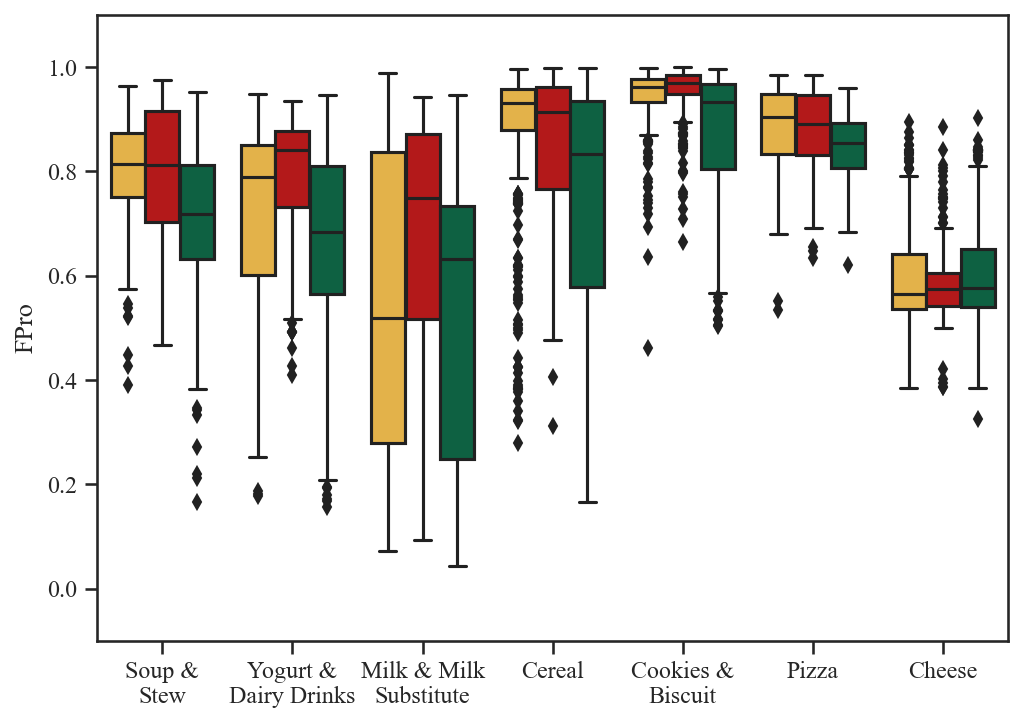

In [43]:
# ['ice-cream', 'Prepared-Foods', 'milk']
cats_labels_dict = {
    'soup-stew': 'Soup &\nStew', 
    'dairy-yogurt-drink': 'Yogurt &\nDairy Drinks', 
    'milk-milk-substitute': 'Milk & Milk\nSubstitute',
    'cereal': 'Cereal',
    'cookies-biscuit': 'Cookies &\nBiscuit', 
#     'ice-cream-dessert': 'IceCream\n& Dessert', 
    'pizza': 'Pizza', 
    'cheese': 'Cheese'
}

cats = [c.lower() for c in cats_labels_dict.keys()]

col_categories = 'harmonized single category'

data_df = gdb_conv_df[gdb_conv_df[col_categories].isin(cats)].reset_index(drop=True)

print(data_df[cols_gdb_standard][col_categories].value_counts())

# (10, 6)
chart_price_per_cal = grocery_base.plot_categories_FPro(
    n_label_x_pad={'Target': -0.25, 'Walmart': 0, 'WholeFoods': +0.25}, 
    legend_bbox_to_anchor=(0.6, 0.3),
#     figsize=(9, 5), 
    figsize=(7, 5), 
    verbose=False,
    dpi=150, col_FPro='f_FPro', col_categories=col_categories,  col_store='store',
    data_df=data_df, remove_legend=True, show_counts=False, order_xaxis = cats, 
    labels_xticks = cats_labels_dict.values(), labels_xticks_rotation=0, xlabel='', ylabel='FPro',
    export_path='output/fig4_A.pdf'
)

10 Nutrients Reported None
Missing Nutrients 0    6665 
2    9096 
4    10962
Name: count, dtype: int64


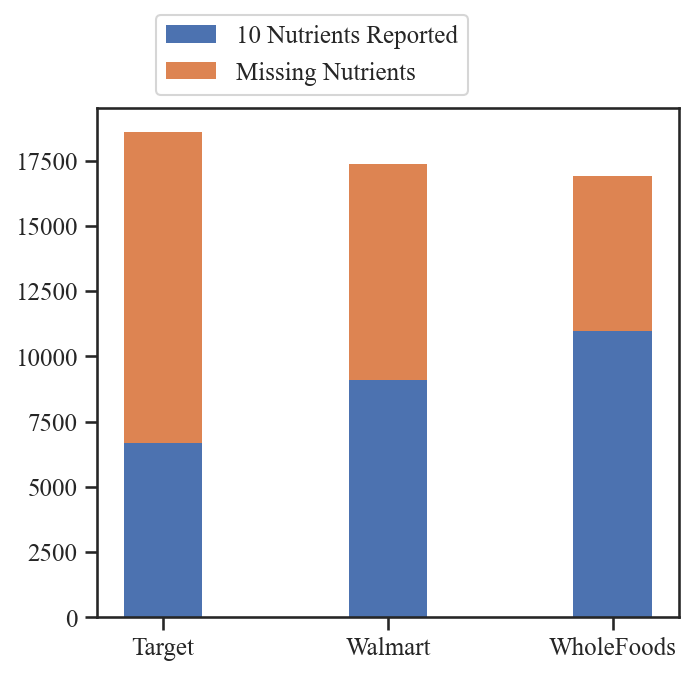

<module 'matplotlib.pyplot' from 'C:\\anaconda3\\envs\\foodome\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [44]:
mask = (~gdb_df['f_min_FPro'].isnull()) & (gdb_df['isConverted'] == 1)
gdb_df.loc[mask, 'status'] = '10 Nutrients Reported'
gdb_df.loc[~mask, 'status'] = 'Missing Nutrients'

gdb_classification_status_df = gdb_df.groupby(['store', 'status']).agg(count = ('original_ID', np.size)).reset_index()
gdb_classification_status_df

grocery_base.plot_bar_classified(gdb_classification_status_df,figsize=(5, 4.5), font_size=12)

## Categories

In [45]:
[c for c in gdb_df.columns if 'cat' in c.lower()]

['store category',
 'store category cleaned str',
 'harmonized category 2',
 'harmonized category 3',
 'harmonized single category',
 'store category cleaned',
 'harmonized category 1',
 'duplicate_IDs',
 'ignore_duplicate']

In [46]:
# store category
store_cats_df = []

for p in gdb_df[['original_ID', 'store', 'store category']].to_dict('records'):
    store_cat = {}
    store_cats_df.append(store_cat)
    
    store_cat['original_ID'] = p['original_ID']
    store_cat['store'] = p['store']
    
    store_cat['cat_depth'] = 0
    
    for i, c in enumerate(p['store category']):
        if c is not None:
            store_cat[i] = str(c)
            store_cat['cat_depth'] += 1
        pass
    pass

store_cats_df = pd.DataFrame(store_cats_df)

store_cats_df.sample(10)

original_ID  \
45762  tg_14898251                                                                                                
5158   wm_10324696                                                                                                
9154   wf_forager-project-organic-dairyfree-strawberry-probiotic-drinkable-cashewmilk-yogurt-8-fl-oz-b0848lrtgh   
19400  wf_lacroix-sparkling-water-pure-sparkling-water-12-pk-b002n3nrio                                           
4282   tg_77525971                                                                                                
36922  wm_10322029                                                                                                
32878  wm_10312430                                                                                                
24418  tg_53147420                                                                                                
39570  tg_17090102                                                                                                
18007  wf_taylors-of-harrogate-assam-black-tea-9efb10                                                             

            store  cat_depth             0                                 1  \
45762  Target      0          NaN           NaN                                
5158   Walmart     3          Eggs & Dairy  Cheese                             
9154   WholeFoods  3          Dairy & Eggs  Dairy Alternatives                 
19400  WholeFoods  2          Beverages     Water, Seltzer & Sparkling Water   
4282   Target      0          NaN           NaN                                
36922  Walmart     3          Pantry        Canned Goods                       
32878  Walmart     3          Pantry        Boxed Dinners                      
24418  Target      0          NaN           NaN                                
39570  Target      0          NaN           NaN                                
18007  WholeFoods  2          beverages     beverages.tea                      

                       2    3    4    5    6  
45762  NaN                NaN  NaN  NaN  NaN  
5158   Block Cheese       NaN  NaN  NaN  NaN  
9154   Cashew             NaN  NaN  NaN  NaN  
19400  NaN                NaN  NaN  NaN  NaN  
4282   NaN                NaN  NaN  NaN  NaN  
36922  Canned Vegetables  NaN  NaN  NaN  NaN  
32878  Dinners            NaN  NaN  NaN  NaN  
24418  NaN                NaN  NaN  NaN  NaN  
39570  NaN                NaN  NaN  NaN  NaN  
18007  NaN                NaN  NaN  NaN  NaN

In [47]:
store_cats_df.fillna('').groupby([0,1,2,3,4,5,6]).agg(count=('original_ID', np.size))

count
0                                                                            1         2                                          3           4                                              5 6       
                                                                                                                                                                                                  19362
365                                                                          beverages beverages.coffee                                                                                           15   
                                                                                       beverages.juice                                                                                            5    
                                                                                       beverages.soft-drinks                                                                                      3    
                                                                                       beverages.sports-energy-nutritional-drinks supplements supplements.sports-nutrition-weight-management      4    
...                                                                                                                                                                                              ..    
{'name': 'Floral', 'slug': 'floral'}                                                                                                                                                              62   
{'name': 'Meat', 'slug': 'meat'}                                                                                                                                                                  4    
{'name': 'Produce', 'slug': 'produce'}                                                                                                                                                            63   
{'name': 'Snacks, Chips, Salsas & Dips', 'slug': 'snacks-chips-salsas-dips'}                                                                                                                      248  
{'name': 'Wine, Beer & Spirits', 'slug': 'wine-beer-spirits'}                                                                                                                                     1    

[812 rows x 1 columns]

In [48]:
cat_level = 3

print('Number of categories at level {}: {}'.format(cat_level, sum(store_cats_df[cat_level].value_counts() > 10)))

store_cats_df[cat_level].value_counts()

Number of categories at level 3: 16


dairy-eggs.milk-cream.whole                         38
dairy-eggs.yogurt                                   29
dairy-eggs.dairy-alternatives.coconut               28
meat.packaged-meat                                  25
dairy-eggs.dairy-alternatives.almond                23
dairy-eggs.dairy-alternatives                       22
desserts.muffins-scones                             21
dairy-eggs.milk-cream.reduced-fat                   18
meat.packaged-poultry                               18
snacks-chips-salsas-dips                            17
dairy-eggs.dairy-alternatives.cashew                17
supplements.sports-nutrition-weight-management      14
seafood.fish                                        13
supplements.specialty-supplements                   12
snacks-chips-salsas-dips.salsas-dips-spreads        11
meat.poultry-counter                                11
dairy-eggs.milk-cream.cow                           9 
meat.pork                                           8 
dairy-eggs

In [49]:
store_cats_df['cat_depth'].value_counts().sort_index()

0    19362
1    471  
2    14079
3    18520
4    356  
5    93   
6    3    
7    1    
Name: cat_depth, dtype: int64

In [50]:
print('Num store categories:', sum(gdb_df['store category cleaned str'].value_counts() > 1))

gdb_df['store category cleaned str'].value_counts()

Num store categories: 698


['none']                                                                       1038
['pantry-essentials', 'condiments-dressings']                                  1001
['grocery', 'pantry', 'sauces-salsa-marinades']                                737 
['pantry-essentials', 'spices-seasonings']                                     704 
['beverages', 'tea']                                                           671 
                                                                              ...  
['deli', 'fresh-prepared-soups-salads', 'pasta-salads']                        1   
['pantry-essentials', 'pasta-noodles', 'prepared-foods', 'prepared-meals']     1   
['frozen-foods', 'frozen-entrees-appetizers', 'meat', 'turkey']                1   
['breads-rolls-bakery', 'rolls-buns', 'desserts', 'pastries-brownies-bars']    1   
['meat', 'packaged-meat', 'turkey']                                            1   
Name: store category cleaned str, Length: 826, dtype: int64

In [51]:
print('Num harmonized categoris:', sum(gdb_df['harmonized single category'].value_counts() > 10))

gdb_df['harmonized single category'].value_counts() > 1

Num harmonized categoris: 57


prepared-meals-dishes      True
pastry-chocolate-candy     True
produce-packaged           True
produce-beans-wf           True
drink-soft-energy-mixes    True
snacks-bars                True
spices-seasoning           True
drink-coffee               True
sauce-all                  True
dressings                  True
cheese                     True
ice-cream-dessert          True
cookies-biscuit            True
meat-packaged              True
drink-tea                  True
drink-juice                True
snacks-chips               True
snacks-mixes-crackers      True
soup-stew                  True
culinary-ingredients       True
cereal                     True
dairy-yogurt-drink         True
baking                     True
no-category                True
bread                      True
milk-milk-substitute       True
rolls-buns-wraps           True
snacks-dips-salsa          True
drink-shakes-other         True
exempt                     True
snacks-nuts-seeds          True
spread-s

In [52]:
len(gdb_df[gdb_df['harmonized single category'] == 'prepared-meals'])

0

In [53]:
column_cat = ['harmonized category 1', 'harmonized single category'][1]

cat_df = pd.merge(
    gdb_df.groupby(column_cat).agg(count_selected_category = ('original_ID', np.size)).reset_index(),
#     gdb_df[['original_ID', 'store', column_cat]],
    gdb_df[['original_ID', 'store', column_cat]],
    on=column_cat
)

len(cat_df[cat_df[column_cat] == 'prepared-meals'])
# cat_df

0

In [54]:
print(len(gdb_df))
print(len(gdb_conv_df))

52885
24233


In [55]:
cat_df.columns
len(gdb_conv_df)

24233

In [56]:
gdb_conv_df.groupby(column_cat).agg(count_selected_category = ('original_ID', np.size)).reset_index()
cat_df

harmonized single category  count_selected_category  \
0      baby-food                  133                       
1      baby-food                  133                       
2      baby-food                  133                       
3      baby-food                  133                       
4      baby-food                  133                       
...          ...                  ...                       
52880  spread-squeeze             670                       
52881  spread-squeeze             670                       
52882  spread-squeeze             670                       
52883  spread-squeeze             670                       
52884  spread-squeeze             670                       

                                                                             original_ID  \
0      wf_green-mountain-creamery-yoyummy-yogurt-squeeze-mixed-berry-35-count-b075m5866t   
1      wf_stonyfield-yobaby-whole-milk-baby-yogurt-pouches-peach-oat-34-oz-b08mkhjznh      
2      wf_stonyfield-yobaby-whole-milk-baby-yogurt-pouches-banana-oat-b089ndpp85           
3      wf_earths-best-stage-2-organic-pears-baby-food-4-oz-b00abprz7a                      
4      wf_kite-hill-strawberry-banana-yogurt-tubes-610f18                                  
...                                                   ...                                  
52880  tg_54538510                                                                         
52881  tg_15183458                                                                         
52882  tg_51495874                                                                         
52883  tg_47567265                                                                         
52884  tg_47110286                                                                         

            store  
0      WholeFoods  
1      WholeFoods  
2      WholeFoods  
3      WholeFoods  
4      WholeFoods  
...           ...  
52880  Target      
52881  Target      
52882  Target      
52883  Target      
52884  Target      

[52885 rows x 4 columns]

In [57]:
gdb_select_df = [
    gdb_conv_df, 
    gdb_df[~gdb_df[column_cat].str.lower().isin(['no-category', 'non-food', 'exempt'])]
][0]
print('len(gdb_select_df):', len(gdb_select_df))

print('Column used for categories:', column_cat)

cat_df = (
    gdb_select_df.groupby(column_cat)
    .agg(count = ('original_ID', np.size)).reset_index()
    .rename(columns={column_cat: 'label'})
)

# if True:
#     cat_df = pd.merge(
#         gdb_select_df.groupby(column_cat).agg(count_selected_category = ('original_ID', np.size)).reset_index(),
#     #     gdb_df
#     #     gdb_df[['original_ID', 'store', column_cat]],
#         gdb_df[['original_ID', 'store', column_cat]],
#         on=column_cat
#     )

#     cat_df = (
#         cat_df[
#     #         (cat_df['count_selected_category'] > 500) & 
#             (~cat_df[column_cat].str.lower().isin(['no-category', 'non-food', 'exempt'])) & 
#             (~cat_df[column_cat].str.lower().isin(cats_ignore_analysis)) 
#         ]
#         .groupby(column_cat)
#         .agg(count=('original_ID', np.size))
#         .sort_values(by='count', ascending=False)
#         .reset_index()
#         .rename(columns={column_cat: 'label'})
#     )

# len(cat_df)
# cat_df


print('Sum products: {}'.format(cat_df['count'].sum()))

len(gdb_select_df): 24233
Column used for categories: harmonized single category
Sum products: 24233


In [58]:
fig = px.pie(
    cat_df, 
    values='count', 
    names='label', 
#     title='Population of European continent',
    width=800, height=800
#     labels=[c + 'X' for c in cat_df['label']]
)

# https://plotly.github.io/plotly.py-docs/generated/plotly.graph_objects.Pie.html
fig.update_traces(
    textposition='inside', 
    textinfo='percent+label',
    texttemplate="%{label}:  %{percent}"
)

fig.update_layout(
    font_family=["Courier New", "Times New Roman"][1],
    font_size=25,
    showlegend=False
)

pio.write_image(fig, 'output/GroceryDB_categories_pie.png', width=800, height=800, scale=3)

fig

In [59]:
cat_df = pd.merge(
    gdb_df.groupby(column_cat).agg(count_selected_category = ('original_ID', np.size)).reset_index(),
#     gdb_df[['original_ID', 'store', column_cat]],
    gdb_df[['original_ID', 'store', column_cat]],
    on=column_cat
)

cat_df['harmonized single category'].value_counts()

prepared-meals-dishes      2830
pastry-chocolate-candy     2665
produce-packaged           2274
produce-beans-wf           2009
drink-soft-energy-mixes    1983
snacks-bars                1776
spices-seasoning           1721
drink-coffee               1688
sauce-all                  1675
dressings                  1630
cheese                     1621
ice-cream-dessert          1524
cookies-biscuit            1467
meat-packaged              1427
drink-tea                  1425
drink-juice                1374
snacks-chips               1335
snacks-mixes-crackers      1273
soup-stew                  1272
culinary-ingredients       1185
cereal                     1168
dairy-yogurt-drink         1161
baking                     1070
no-category                933 
bread                      909 
milk-milk-substitute       904 
rolls-buns-wraps           830 
snacks-dips-salsa          805 
drink-shakes-other         803 
exempt                     738 
snacks-nuts-seeds          679 
spread-s

Num categories: 42


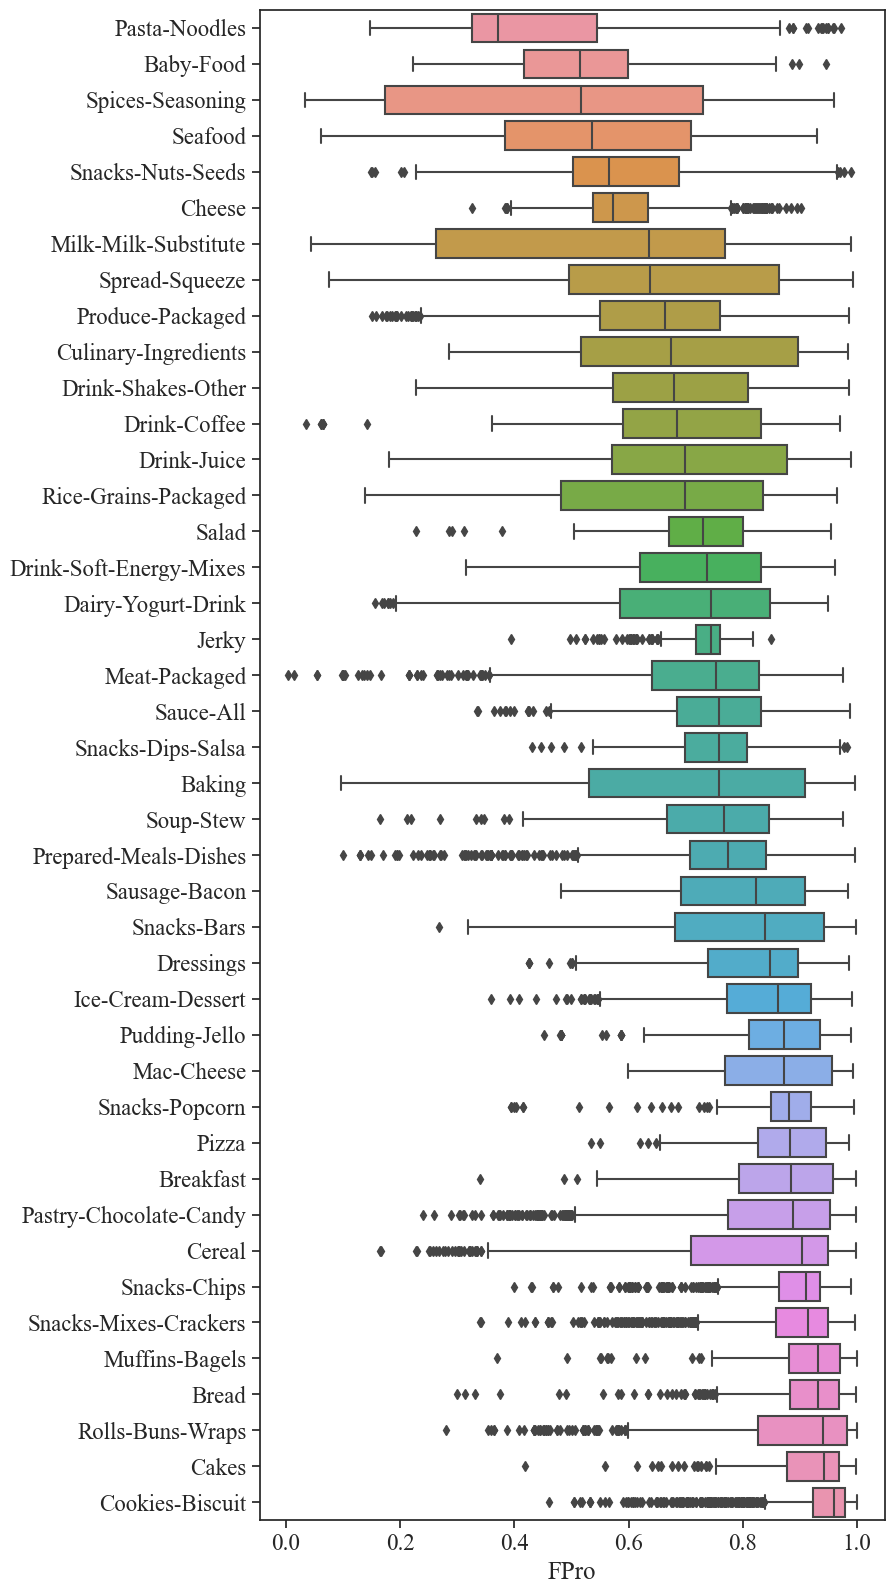

In [60]:
'''
FPro Dist Bar Chart
'''

cat_count_cutoff = 100

ax = grocery_base.plot_all_categories_FPro(
    gdb_conv_df[
        (gdb_conv_df['count_products_category'] > cat_count_cutoff) & 
        (~(gdb_conv_df['harmonized single category'].str.lower().isin(cats_ignore_analysis)))
       ], 
    col_FPro="f_FPro", col_category='harmonized single category', font_scale=1.5, figsize = (9, 16),
    verbose=False,
    export_path='output/fig2_B.pdf'
)

## Tree Width corr Depth | Corr FPro

In [61]:
len(gdb_conv_df)
[c for c in gdb_conv_df.columns if 'tree' in c.lower()]

['tree_height',
 'tree_width',
 'bad_tree',
 'sim_ingreds_oID_list_from_trees',
 'tree_branch_depth_sum']

In [62]:
cat = ['pudding-jello', 'sausage-bacon', 'bread', 'milk-milk-substitute'][1]

print('cat:', cat)

df = gdb_conv_df[gdb_conv_df[column_cat] == cat][
    ['original_ID', 'name', 'store', 'f_FPro', 'tree_width', 'tree_height', 'tree_branch_depth_sum']
].sort_values(by='tree_branch_depth_sum', ascending=False)

print(sum(df['tree_branch_depth_sum'] > 0), 'with D==0 from', len(df), 'items')

print('compare width G1(D=0): {} vs G2(D>0): {}'.format(
    df[df['tree_branch_depth_sum'] == 0]['tree_width'].mean(),
    df[df['tree_branch_depth_sum'] > 0]['tree_width'].mean()
))

df

cat: sausage-bacon
284 with D==0 from 466 items
compare width G1(D=0): 9.630573248407643 vs G2(D>0): 6.049295774647887


original_ID  \
17853  wm_389701511                                                                             
17766  wf_niman-ranch-voodoo-ranger-mango-habenero-pork-sausage-b082vvw5gn                      
17866  wm_36032547                                                                              
18022  wm_951474066                                                                             
18055  tg_50542211                                                                              
18077  tg_14624529                                                                              
17972  wm_44684591                                                                              
17830  wf_field-roast-italian-garlic-fennel-plantbased-sausage-b002dqp04u                       
18068  tg_78901005                                                                              
18154  tg_47561770                                                                              
17969  wm_192097986                                                                             
17872  wm_153383515                                                                             
17732  wf_lightlife-gimme-lean-vegan-breakfast-sausage-b000qj8df4                               
18174  tg_54311099                                                                              
18042  wm_181757524                                                                             
18097  tg_47995327                                                                              
17800  wf_whole-foods-market-organic-feta-spinach-chicken-sausage-b084lnjc2d                    
18011  wm_39384175                                                                              
17976  wm_113681460                                                                             
18090  tg_81638102                                                                              
18009  wm_46548483                                                                              
18052  tg_54645401                                                                              
17970  wm_51258928                                                                              
18004  wm_49914836                                                                              
18067  tg_78901008                                                                              
17773  wf_whole-foods-market-organic-mushroom-parmesan-chicken-sausage-b084lnlgdc               
17882  wm_759487618                                                                             
17998  wm_44391031                                                                              
18094  tg_79834591                                                                              
17815  wf_north-country-smokehouse-jalapeno-cheddar-sausage-b07qbvl964                          
17814  wf_lightlife-gimme-lean-meatless-veggie-sausage-b000qj8df4                               
17776  wf_applegate-mild-spinach-feta-chicken-sausage-b001w3osg6                                
18117  tg_50865543                                                                              
18074  tg_53129350                                                                              
17978  wm_44391058                                                                              
17826  wf_niman-ranch-apple-gouda-uncured-sausage-b074zf9cbs                                    
17865  wm_19276113                                                                              
18008  wm_113898075                                                                             
18046  tg_79559779                                                                              
18013  wm_44391052                                                                              
17741  wf_whole-foods-market-organic-parmesan-mushroom-chicken-sausage-364e89                   
17744  w

In [63]:
column_cat = 'harmonized single category'

gdb_filt_df = gdb_conv_df[gdb_conv_df['bad_tree'] == False].reset_index(drop=True)

cat_df = pd.merge(
    gdb_filt_df.groupby(column_cat).agg(count_selected_category = ('original_ID', np.size)).reset_index(),
    gdb_filt_df[['original_ID', 'store', column_cat]],
    on=column_cat
)

cat_df = gdb_df.groupby(column_cat).agg(count_selected_category = ('original_ID', np.size)).reset_index()

print(len(gdb_filt_df))

23213


In [64]:
column_cat = 'harmonized single category'
col_tree_width = 'tree_width'
col_tree_depth = ['tree_height', 'tree_branch_depth_sum'][1]
col_FPro = 'f_FPro'
col_num_ingreds_additives = 'num_ingred_additive'

gdb_filt_df[col_num_ingreds_additives] = gdb_filt_df['num_additives'] + gdb_filt_df['num_ingredients']

gdb_tree_spec_FPro_df = pd.merge(
    gdb_filt_df[['original_ID', 'store', column_cat, col_FPro, col_tree_width, col_tree_depth, col_num_ingreds_additives]],
    cat_df,
    on=column_cat
)

gdb_tree_spec_FPro_df = gdb_tree_spec_FPro_df[
    ~gdb_tree_spec_FPro_df.isnull().any(axis=1)].reset_index(drop=True)

print('col_tree_depth:', col_tree_depth)

# len(gdb_tree_spec_df['original_ID'].unique())
print(len(gdb_tree_spec_FPro_df))
gdb_tree_spec_FPro_df.head()

col_tree_depth: tree_branch_depth_sum
23213


original_ID  \
0  wf_green-mountain-creamery-yoyummy-yogurt-squeeze-mixed-berry-35-count-b075m5866t   
1  wf_stonyfield-yobaby-whole-milk-baby-yogurt-pouches-peach-oat-34-oz-b08mkhjznh      
2  wf_stonyfield-yobaby-whole-milk-baby-yogurt-pouches-banana-oat-b089ndpp85           
3  wf_kite-hill-strawberry-banana-yogurt-tubes-610f18                                  
4  wf_plum-organics-organic-mighty-strawberry-spinach-baby-food-6-count-78faf3         

        store harmonized single category    f_FPro  tree_width  \
0  WholeFoods  baby-food                  0.897833  17.0         
1  WholeFoods  baby-food                  0.829028  9.0          
2  WholeFoods  baby-food                  0.829028  9.0          
3  WholeFoods  baby-food                  0.599306  12.0         
4  WholeFoods  baby-food                  0.945944  3.0          

   tree_branch_depth_sum  num_ingred_additive  count_selected_category  
0  0.0                    17.0                 133                      
1  2.0                    14.0                 133                      
2  0.0                    9.0                  133                      
3  4.0                    18.0                 133                      
4  8.0                    48.0                 133

In [65]:
'''
THIS IS ONLY FOR PRDOUCTS THAT HAVE FPro ~ 24897
'''
cat_tree_spec_FPro_corr_df = []

for cat in gdb_tree_spec_FPro_df[
        gdb_tree_spec_FPro_df['count_selected_category'] > 0
    ][column_cat].unique():
#     print(cat)
    cat_df = gdb_tree_spec_FPro_df[gdb_tree_spec_FPro_df[column_cat] == cat]
    
    cat_corr_dict = {
        'cat': cat,
        'count items': len(cat_df)#cat_df['count_have_PricePerCal_category'].unique()[0]
        
    }
    cat_tree_spec_FPro_corr_df.append(cat_corr_dict)
    
    corr, corr_pval = stats.spearmanr(cat_df[col_tree_width], cat_df[col_tree_depth])
    cat_corr_dict['all width and depth'] = corr
    
    corr, corr_pval = stats.spearmanr(cat_df[col_tree_width], cat_df[col_FPro])
    cat_corr_dict['all width and FPro'] = corr
    
    corr, corr_pval = stats.spearmanr(cat_df[col_tree_depth], cat_df[col_FPro])
    cat_corr_dict['all depth and FPro'] = corr
    
    corr, corr_pval = stats.spearmanr(cat_df[col_num_ingreds_additives], cat_df[col_FPro])
    cat_corr_dict['all ing_add and FPro'] = corr
    
    
    for store in grocery_base.stores:
        cat_store_df = cat_df[cat_df['store'] == store]
        cat_corr_dict[store + ' count items'] = len(cat_store_df)
        cat_corr_dict[store + ' width'] = None
        cat_corr_dict[store + ' depth'] = None
        cat_corr_dict[store + ' ing_add'] = None
        
        if len(cat_store_df) > 30:
            corr, corr_pval = stats.spearmanr(cat_store_df[col_tree_width], cat_store_df[col_tree_depth])
            cat_corr_dict[store + ' width and depth'] = corr
            
            corr, corr_pval = stats.spearmanr(cat_store_df[col_tree_width], cat_store_df[col_FPro])
            cat_corr_dict[store + ' width and FPro'] = corr
            
            corr, corr_pval = stats.spearmanr(cat_store_df[col_tree_depth], cat_store_df[col_FPro])
            cat_corr_dict[store + ' depth and FPro'] = corr
            
            corr, corr_pval = stats.spearmanr(cat_store_df[col_num_ingreds_additives], cat_store_df[col_FPro])
            cat_corr_dict[store + ' ing_add and FPro'] = corr
            pass
        pass
    
#     break
    pass

cat_tree_spec_FPro_corr_df = pd.DataFrame(cat_tree_spec_FPro_corr_df).sort_values(
    by=['all width and FPro'], ascending=[False]
)

if False:
    grocery_base.save_xls(
        cat_tree_spec_FPro_corr_df, 'GDB Tree Specs correlation FPro.xlsx', True, False
    )

# Remove wholefood items
# cat_tree_spec_FPro_corr_df = cat_tree_spec_FPro_corr_df[~cat_tree_spec_FPro_corr_df['cat'].str.endswith('-wf')].reset_index(drop=True)

cat_tree_spec_FPro_corr_df = (
    cat_tree_spec_FPro_corr_df[~cat_tree_spec_FPro_corr_df['cat'].isin(cats_ignore_analysis)].reset_index(drop=True)
)
    
print(len(cat_tree_spec_FPro_corr_df))
cat_tree_spec_FPro_corr_df


43


cat  count items  all width and depth  \
0   spices-seasoning         231          0.459857              
1   rice-grains-packaged     125          0.215953              
2   culinary-ingredients     190          0.529478              
3   drink-tea                93           0.157045              
4   milk-milk-substitute     399          0.413229              
5   baking                   370          0.404933              
6   seafood                  365          0.344491              
7   spread-squeeze           298          0.049727              
8   breakfast                262         -0.010406              
9   snacks-mixes-crackers    1012         0.140131              
10  sauce-all                650          0.077721              
11  cereal                   786          0.238827              
12  pasta-noodles            248          0.138566              
13  dressings                565          0.273508              
14  produce-packaged         1085         0.167443              
15  cheese                   990         -0.060872              
16  dairy-yogurt-drink       791         -0.156956              
17  meat-packaged            848         -0.113980              
18  pastry-chocolate-candy   1472         0.059322              
19  rolls-buns-wraps         647         -0.006113              
20  pizza                    296          0.269098              
21  baby-food                123          0.095328              
22  snacks-bars              1364         0.103352              
23  snacks-chips             953          0.150534              
24  snacks-popcorn           206          0.208374              
25  snacks-dips-salsa        445          0.092599              
26  cookies-biscuit          1159        -0.092311              
27  ice-cream-dessert        869         -0.223868              
28  drink-juice              382          0.134497              
29  drink-coffee             220          0.122328              
30  drink-soft-energy-mixes  135          0.149235              
31  muffins-bagels           249         -0.118590              
32  sausage-bacon            439         -0.421839              
33  bread                    670         -0.267713              
34  prepared-meals-dishes    1875         0.072543              
35  cakes                    376          0.144010              
36  jerky                    224         -0.166001              
37  snacks-nuts-seeds        346          0.029011              
38  drink-shakes-other       301          0.213762              
39  soup-stew                609         -0.169738              
40  salad                    114         -0.134970              
41  pudding-jello            219         -0.436266              
42  mac-cheese               212          0.211608              

    all width and FPro  all depth and FPro  all ing_add and FPro  \
0   0.760262            0.458142            0.786125               
1   0.655145            0.302267            0.630643               
2   0.584202            0.479368            0.649054               
3   0.581323            0.002724            0.471670               
4   0.576368            0.430303            0.647402               
5   0.554636            0.667198            0.752096               
6   0.476698            0.624044            0.719885               
7   0.398507            0.255892            0.480115               
8   0.396331            0.081226            0.088770               
9   0.361202            0.383627            0.452161               
10  0.351149            0.251537            0.495956               
11  0.350611            0.231930            0.450810               
12  0.347290            0.179053            0.364860               
13  0.334236            0.210401            0.376323               
14  0.330293            0.174770            0.401799               
15  0.328091            0.210017            0.402487               
16  0.3

col_tree_depth: tree_branch_depth_sum


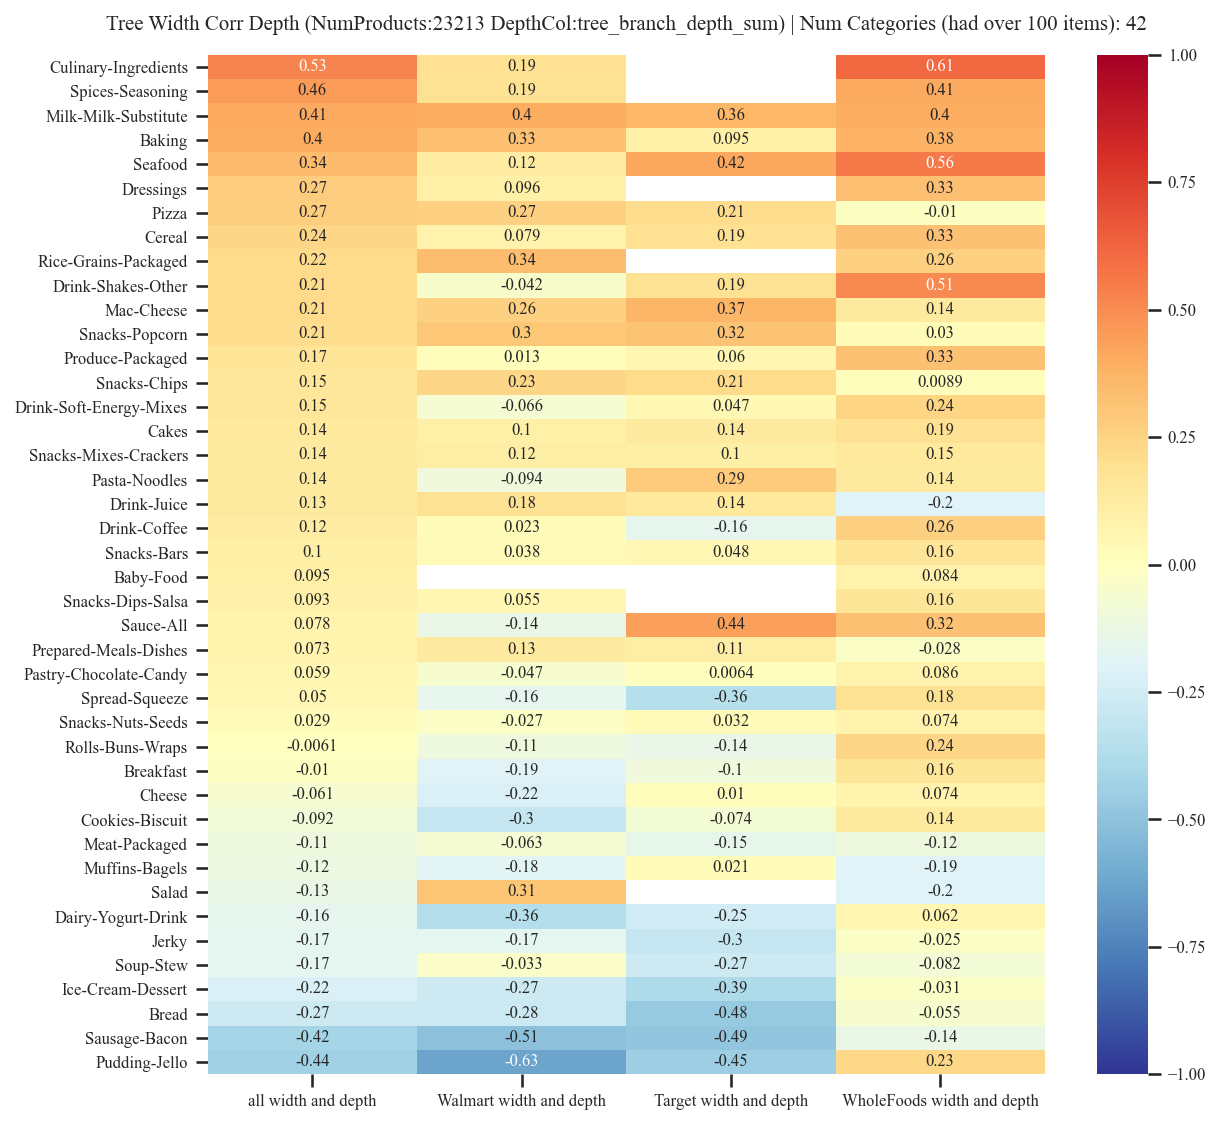

In [66]:
cat_tree_spec_FPro_corr_df = pd.DataFrame(cat_tree_spec_FPro_corr_df).sort_values(
    by='all width and depth', ascending=[False]
)

print('col_tree_depth:', col_tree_depth)

res = grocery_base.plot_correlation_matrix(
    cat_corr_df=cat_tree_spec_FPro_corr_df, 
#     cols_heatmap = [c for c in cat_tree_spec_FPro_corr_df.columns if 'width' in c or 'depth' in c],
    cols_heatmap = ['all width and depth', 'Walmart width and depth', 'Target width and depth', 'WholeFoods width and depth'],
    filter_min_num_items_in_category=100,
    title='Tree Width Corr Depth (NumProducts:{} DepthCol:{})'.format(len(gdb_tree_spec_FPro_df), col_tree_depth), 
    figsize=(9, 9),
    vmin_vmax=(-1,1),
    font_size=8, add_count_items=False
)

col_tree_depth: tree_branch_depth_sum


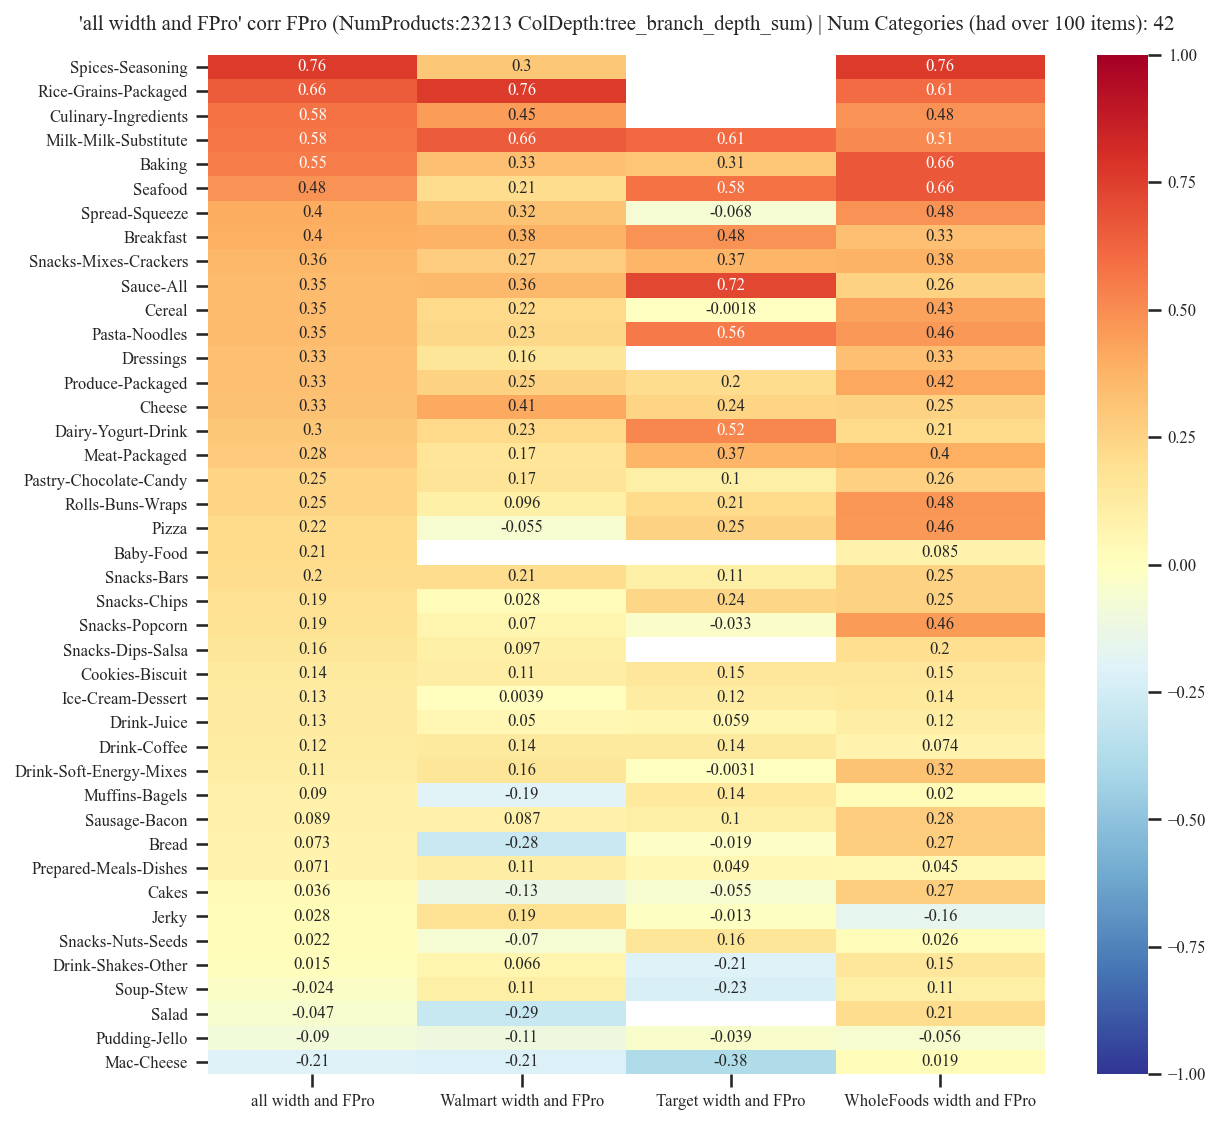

In [67]:
col = ['all width and FPro', 'all depth and FPro', 'all ing_add and FPro'][0]

cat_tree_spec_FPro_corr_df = pd.DataFrame(cat_tree_spec_FPro_corr_df).sort_values(
    by=col, ascending=[False]
)

print('col_tree_depth:', col_tree_depth)

res = grocery_base.plot_correlation_matrix(
    cat_corr_df=cat_tree_spec_FPro_corr_df, 
#     cols_heatmap = [c for c in cat_tree_spec_FPro_corr_df.columns if 'width' in c or 'depth' in c],
    cols_heatmap = [col, 'Walmart' + col[3:], 'Target' + col[3:], 'WholeFoods' + col[3:]],
    filter_min_num_items_in_category=100,
    title='\'{}\' corr FPro (NumProducts:{} ColDepth:{})'.format(col, len(gdb_tree_spec_FPro_df), col_tree_depth), 
    vmin_vmax=(-1,1),
    figsize=(9, 9), font_size=8, add_count_items=False
)

col_tree_depth: tree_branch_depth_sum


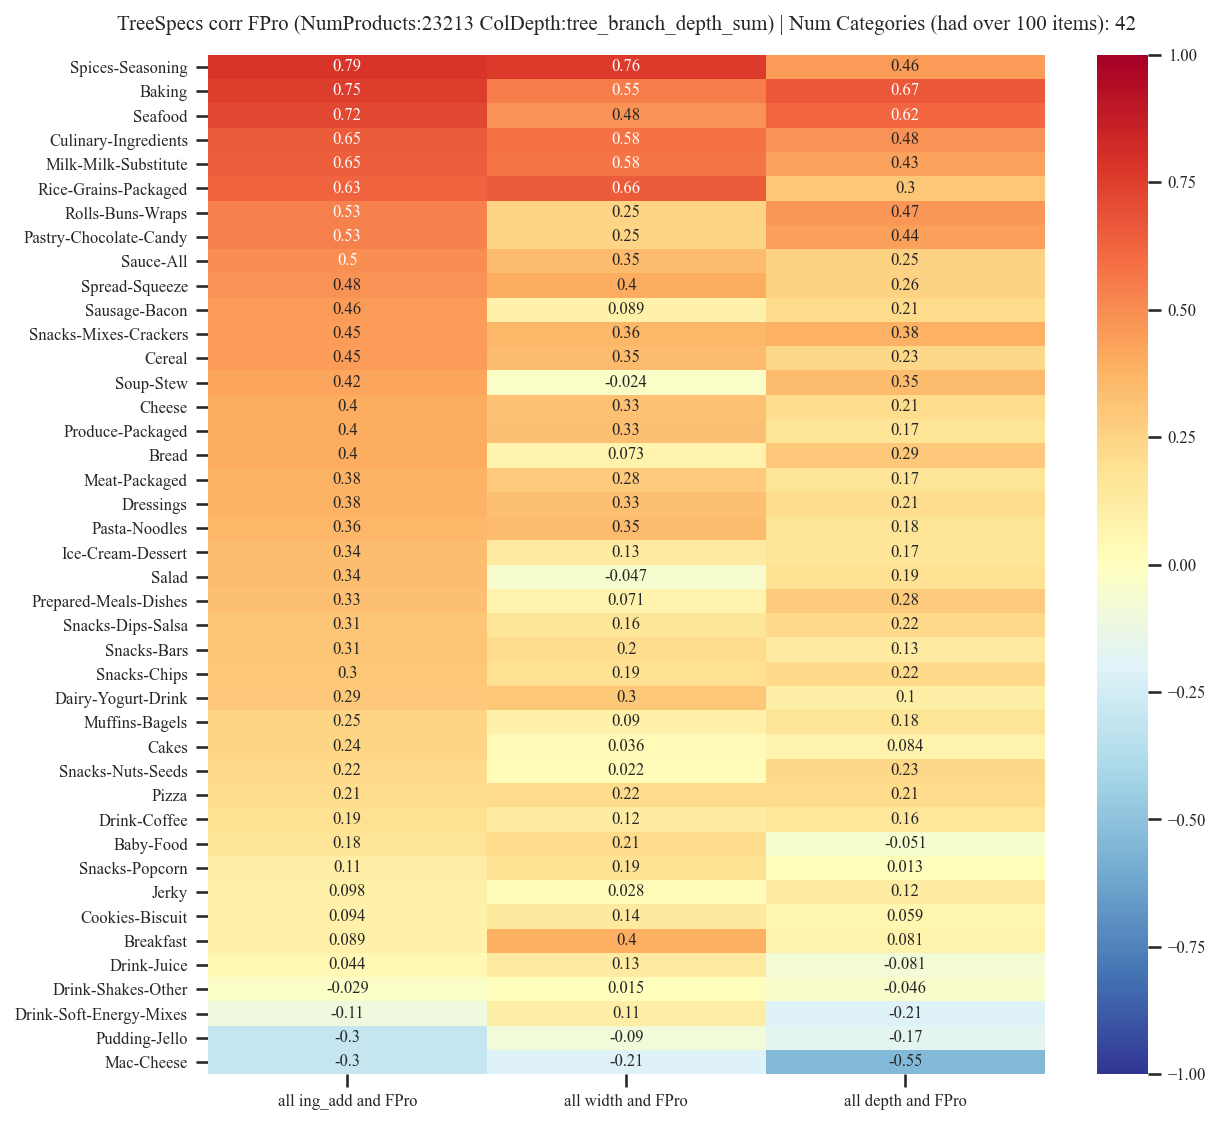

In [68]:
cols_heatmap = ['all ing_add and FPro', 'all width and FPro', 'all depth and FPro']

cat_tree_spec_FPro_corr_df = pd.DataFrame(cat_tree_spec_FPro_corr_df).sort_values(
    by=cols_heatmap[0], ascending=[False]
)

print('col_tree_depth:', col_tree_depth)

res = grocery_base.plot_correlation_matrix(
    cat_corr_df=cat_tree_spec_FPro_corr_df, 
#     cols_heatmap = [c for c in cat_tree_spec_FPro_corr_df.columns if 'width' in c or 'depth' in c],
    cols_heatmap = cols_heatmap,
    filter_min_num_items_in_category=100,
    title='TreeSpecs corr FPro (NumProducts:{} ColDepth:{})'.format(len(gdb_tree_spec_FPro_df), col_tree_depth), 
    vmin_vmax=(-1,1),
    figsize=(9, 9), font_size=8, add_count_items=False
)

In [69]:
gdb_tree_spec_FPro_df.describe()

f_FPro    tree_width  tree_branch_depth_sum  num_ingred_additive  \
count  23213.000000  23213.000000  23213.000000           23213.000000          
mean   0.767647      9.141559      3.136260               19.845087             
std    0.184211      6.331421      3.495326               17.089725             
min    0.003611      1.000000      0.000000               1.000000              
25%    0.659500      4.000000      0.000000               8.000000              
50%    0.808204      8.000000      2.000000               16.000000             
75%    0.917167      12.000000     5.000000               26.000000             
max    0.999056      65.000000     40.000000              167.000000            

       count_selected_category  
count  23213.000000             
mean   1438.493775              
std    723.732934               
min    133.000000               
25%    904.000000               
50%    1374.000000              
75%    1776.000000              
max    2830.000000

col_tree_depth: tree_branch_depth_sum
['cakes', 'pizza']


[Text(0.5, 0, 'Width'), Text(0, 0.5, '$D_s$')]

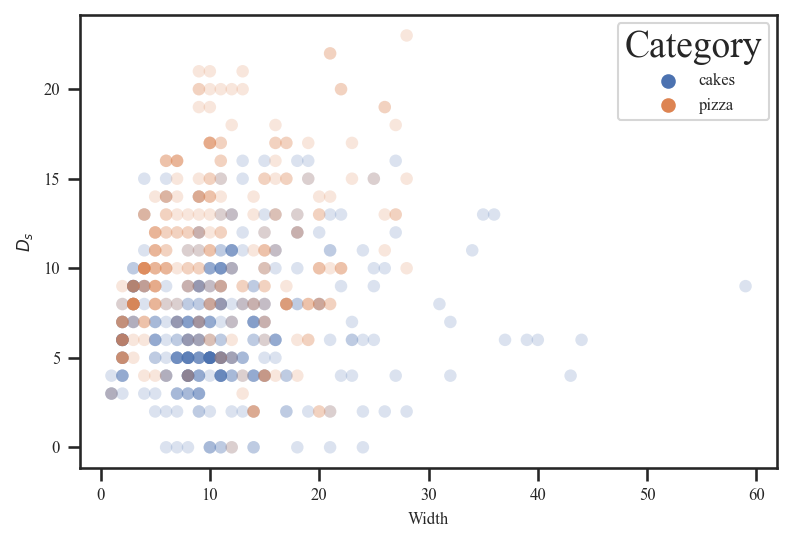

In [70]:
print('col_tree_depth:', col_tree_depth)

categories = ['baking', 'pizza', 'cheese',
              'cakes', 'prepared-meals-dishes', 'sausage-bacon', 'drink-coffee'][2:4]

categories = ['cakes', 'pizza']
# categories = ['cakes', 'cheese']
# categories = ['cakes', 'baking']
# categories = ['cakes', 'sausage-bacon']
# categories = ['cakes', 'mac-cheese']
# categories = ['cakes', 'pudding-jello']
# categories = ['mac-cheese', 'pudding-jello']

print(categories)
data_df = gdb_tree_spec_FPro_df[gdb_tree_spec_FPro_df['harmonized single category'].isin(categories)]

count_products_min = 100

fig, axs = plt.subplots(1, figsize=(6, 4), dpi=150)

g = sns.scatterplot(
    data=data_df[data_df[col_tree_depth] < 30], 
    x="tree_width", y=col_tree_depth,
#     size="count_used", sizes=(20, 200),
#     size=1,
    hue='harmonized single category', alpha=0.20, linewidth=0, 
)

plt.legend(title='Category'#, loc='upper left', labels=['Hell Yeh', 'Nah Bruh']
          )

g.set(xlabel='Width', ylabel='$D_s$')
# g.set(title='count_products_min: {} | col_ingred_name: {}'.format(count_products_min, col_ingred_name))


col_tree_depth: tree_branch_depth_sum


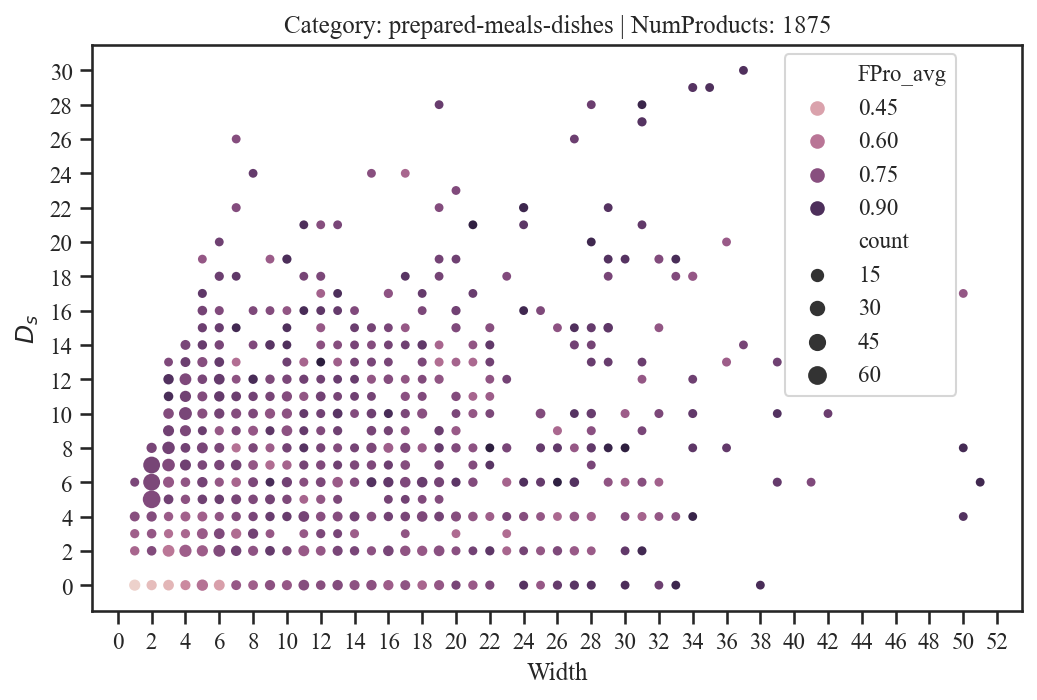

In [71]:
set_fonts(font_size=5, font_scale=1.0)
print('col_tree_depth:', col_tree_depth)

def plot_avg_FPro_tree_specs(category, verbose, legend_anchor):    
    data_df = gdb_tree_spec_FPro_df[gdb_tree_spec_FPro_df['harmonized single category'].isin([category])]
    data_avg_df = data_df.groupby(["tree_width", col_tree_depth]).agg(
        FPro_avg = ('f_FPro', np.mean),
        count = ('original_ID', np.size)
    ).reset_index()

    fig, axs = plt.subplots(1, figsize=(8, 5), dpi=150)

    g = sns.scatterplot(
        data=data_avg_df[data_avg_df[col_tree_depth] < 32], 
        x="tree_width", y=col_tree_depth,
    #     size="count_used", sizes=(20, 200),
    #     size=1, alpha=0.90,
        hue='FPro_avg', linewidth=0, size='count'
    )

    g.xaxis.set_major_locator(ticker.MultipleLocator(2))
    # g.xaxis.set_major_formatter(ticker.ScalarFormatter())
    g.yaxis.set_major_locator(ticker.MultipleLocator(2))
    # g.yaxis.set_major_formatter(ticker.ScalarFormatter())
#     g.legend( bbox_to_anchor=(1.00, 1.01)) #loc='center left', bbox_to_anchor=(1, 0.5)
    g.legend( bbox_to_anchor=legend_anchor)

    # plt.legend(title='Category'#, loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])

    g.set(xlabel='Width', ylabel='$D_s$')
    
    title = 'Category: {} | NumProducts: {}'.format(category, len(data_df))
    
    if verbose:
        g.set(title=title)
    else:
        print(title)
    pass

category = [
    'baking', 'mac-cheese', 'cakes', 'pudding-jello', 'pizza', 'cheese',
    'prepared-meals-dishes', 'sausage-bacon', 'drink-coffee', 'ice-cream-dessert', 'pasta-noodles',
    'seafood', 'cereal', 'pizza'
][6]
legend_anchor_dict = {'cereal': (0.72, 0.38), 'pasta-noodles': (0.79, 0.32), 'baking': (0.79, 0.41),
                     'prepared-meals-dishes': (0.732, 0.36)}
legend_anchor_val = (1.00, 1.01)
if category in legend_anchor_dict:
    legend_anchor_val = legend_anchor_dict[category]
plot_avg_FPro_tree_specs(category, verbose=True, legend_anchor=legend_anchor_val)

# Tree Dists

In [72]:
column_cat = 'harmonized single category'

gdb_filt_df = gdb_df[gdb_df['bad_tree'] == False]

cat_df = pd.merge(
    gdb_filt_df.groupby(column_cat).agg(count_selected_category = ('original_ID', np.size)).reset_index(),
    gdb_filt_df[['original_ID', 'store', column_cat]],
    on=column_cat
)

cat_df = gdb_filt_df.groupby(column_cat).agg(count_selected_category = ('original_ID', np.size)).reset_index()

print(len(gdb_filt_df))
# cat_df

column_cat = 'harmonized single category'
col_tree_width = 'tree_width'
col_tree_depth = ['tree_depth', 'tree_branch_depth_sum'][1]

print('col_tree_depth:', col_tree_depth)

cat_tree_spec_FPro_corr_df

gdb_tree_spec_df = pd.merge(
    gdb_filt_df[['original_ID', 'store', column_cat, col_tree_width, col_tree_depth]],
    cat_df,
    on=column_cat
)

gdb_tree_spec_df = gdb_tree_spec_df[~gdb_tree_spec_df.isnull().any(axis=1)].reset_index(drop=True)

# len(gdb_tree_spec_df['original_ID'].unique())
print(len(gdb_tree_spec_df))
gdb_tree_spec_df.head()

47675
col_tree_depth: tree_branch_depth_sum
47675


original_ID  \
0  wf_green-mountain-creamery-yoyummy-yogurt-squeeze-mixed-berry-35-count-b075m5866t   
1  wf_stonyfield-yobaby-whole-milk-baby-yogurt-pouches-peach-oat-34-oz-b08mkhjznh      
2  wf_stonyfield-yobaby-whole-milk-baby-yogurt-pouches-banana-oat-b089ndpp85           
3  wf_earths-best-stage-2-organic-pears-baby-food-4-oz-b00abprz7a                      
4  wf_kite-hill-strawberry-banana-yogurt-tubes-610f18                                  

        store harmonized single category  tree_width  tree_branch_depth_sum  \
0  WholeFoods  baby-food                  17.0        0.0                     
1  WholeFoods  baby-food                  9.0         2.0                     
2  WholeFoods  baby-food                  9.0         0.0                     
3  WholeFoods  baby-food                  3.0         0.0                     
4  WholeFoods  baby-food                  12.0        4.0                     

   count_selected_category  
0  130                      
1  130                      
2  130                      
3  130                      
4  130

In [73]:
'''DECIDE IF YOU WANNA ONLY WOR ON ITEMS THAT WE HAVE FPro'''
if True:
    gdb_tree_spec_df = gdb_tree_spec_df[gdb_tree_spec_df['original_ID'].isin(gdb_conv_df['original_ID'])].reset_index(drop=True)

'''Only include the selected categories (basically drops unprocessed foods)'''
if False:   
    gdb_tree_spec_df = gdb_tree_spec_df[
        gdb_tree_spec_df[col_categories].isin(gdb_conv_df[col_categories].unique())
    ].reset_index(drop=True)
    
    print(len(gdb_tree_spec_df))

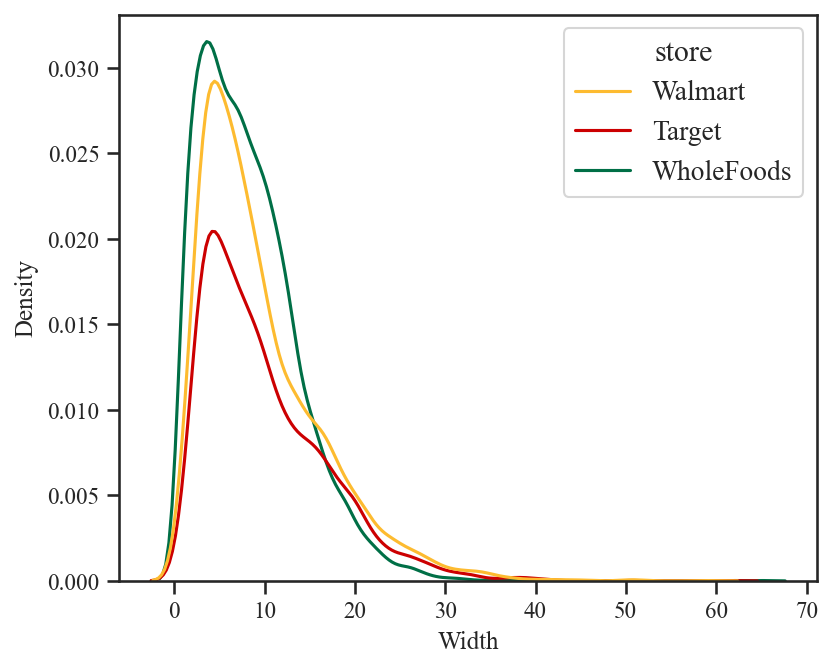

In [74]:
fig, axs = plt.subplots(1, figsize=(6,5), dpi=150)

sns.set(style="ticks", font="Times New Roman", font_scale=1.2)
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})

ax = sns.kdeplot(data=gdb_tree_spec_df, x=col_tree_width, hue='store', ax=axs,
                 palette=grocery_base.colors_stores, hue_order=grocery_base.colors_stores.keys())
# ax = sns.histplot(data=gdb_tree_spec_df, x=col_tree_width, hue='store', ax=axs)


# ax.set(ylim=(0, 2500))

ax.set(xlabel='Width', ylabel='Density')

if False:
    plt.title(
        'Distribution of Tree Width | Num Data: {}'.format(
            len(gdb_tree_spec_df)))
    pass

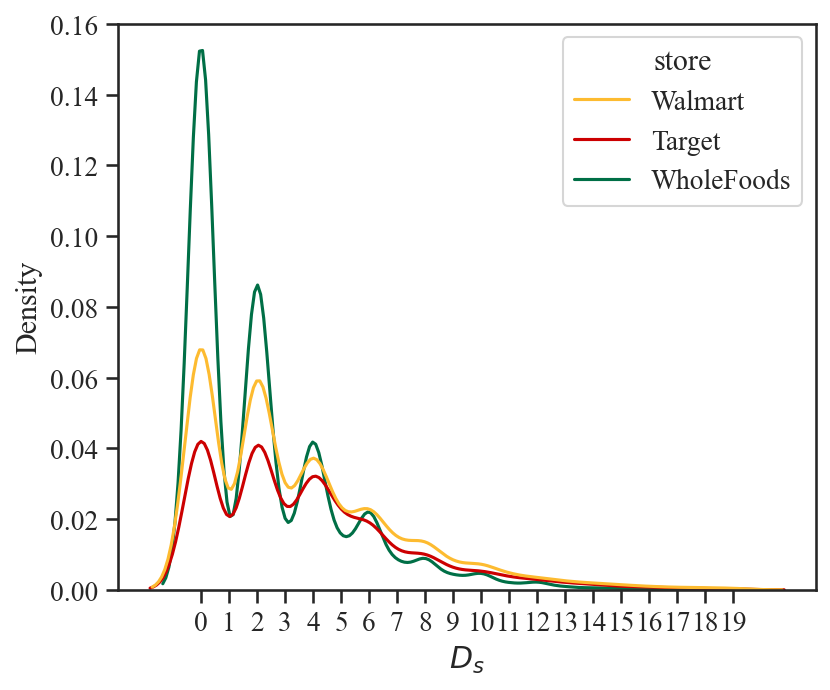

In [75]:
fig, axs = plt.subplots(1, figsize=(6,5), dpi=150)

sns.set(style="ticks", font="Times New Roman", font_scale=1.2)
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})

data_df = gdb_tree_spec_df[gdb_tree_spec_df[col_tree_depth] < 20]

ax = sns.kdeplot(data=data_df, x=col_tree_depth, hue='store', ax=axs,
                palette=grocery_base.colors_stores, hue_order=grocery_base.colors_stores.keys())
# ax = sns.histplot(data=gdb_tree_spec_df, x=col_tree_depth, hue='store', ax=axs)

ax.set(xlabel='$D_s$', ylabel='Density')

plt.xticks(range(0, int(data_df[col_tree_depth].max()) + 1, 1))

if False:
    plt.title(
        'Distribution of Tree depth | Num Data: {}'.format(
            len(gdb_tree_spec_df)))

In [76]:
'''DECIDE IF YOU WANNA ONLY WOR ON ITEMS THAT WE HAVE FPro'''
if True:
    gdb_tree_spec_df = gdb_tree_spec_df[gdb_tree_spec_df['original_ID'].isin(gdb_conv_df['original_ID'])].reset_index(drop=True)

'''Only include selected categories (since you only manually ensured items that have FPro are in the correct category, there might be some items with not perfect category harmonization)'''
if True:
    gdb_tree_spec_df = gdb_tree_spec_df[
        gdb_tree_spec_df[col_categories].isin(gdb_conv_df[col_categories].unique())
    ].reset_index(drop=True)
    
    print(len(gdb_tree_spec_df))

23213


In [77]:
cat_tree_spects_corr_df = []

print(len(gdb_tree_spec_df))

for cat in gdb_tree_spec_df[
        gdb_tree_spec_df['count_selected_category'] > 0
    ][column_cat].unique():
#     print(cat)
    cat_df = gdb_tree_spec_df[gdb_tree_spec_df[column_cat] == cat]
    
    cat_corr_dict = {
        'cat': cat,
        'count items': len(cat_df)#cat_df['count_have_PricePerCal_category'].unique()[0]
        
    }
    cat_tree_spects_corr_df.append(cat_corr_dict)
    
    corr, corr_pval = stats.spearmanr(cat_df[col_tree_width], cat_df[col_tree_depth])
    cat_corr_dict['all'] = corr
    
    cat_corr_dict['all ' + col_tree_width + ' mean'] = cat_df[col_tree_width].mean()
    cat_corr_dict['all ' + col_tree_width + ' std'] = cat_df[col_tree_width].std()

    cat_corr_dict['all ' + col_tree_depth + ' mean'] = cat_df[col_tree_depth].mean()
    cat_corr_dict['all ' + col_tree_depth + ' std'] = cat_df[col_tree_depth].std()
    
    for store in grocery_base.stores:
        cat_store_df = cat_df[cat_df['store'] == store]
        cat_corr_dict[store] = None
        cat_corr_dict[store + ' count items'] = len(cat_store_df)
        
        cat_corr_dict[store + ' ' + col_tree_width + ' mean'] = cat_store_df[col_tree_width].mean()
        cat_corr_dict[store + ' ' + col_tree_width + ' std'] = cat_store_df[col_tree_width].std()
        
        cat_corr_dict[store + ' ' + col_tree_depth + ' mean'] = cat_store_df[col_tree_depth].mean()
        cat_corr_dict[store + ' ' + col_tree_depth + ' std'] = cat_store_df[col_tree_depth].std()
        
        if len(cat_store_df) > 10:
            corr, corr_pval = stats.spearmanr(cat_store_df[col_tree_width], cat_store_df[col_tree_depth])
            cat_corr_dict[store] = corr
            pass
        pass
    
#     break
    pass

cat_tree_spects_corr_df = pd.DataFrame(cat_tree_spects_corr_df).sort_values(by='all', ascending=False)

if False:
    grocery_base.save_xls(
        cat_tree_spects_corr_df, 'GDB Tree Specs correlation.xlsx', True, False
    )

print(len(cat_tree_spects_corr_df))
cat_tree_spects_corr_df

23213
43


cat  count items       all  all tree_width mean  \
8   culinary-ingredients     190          0.529478  5.094737              
41  spices-seasoning         231          0.459857  5.766234              
20  milk-milk-substitute     399          0.413229  5.526316              
1   baking                   370          0.404933  5.781081              
33  seafood                  365          0.344491  5.830137              
10  dressings                565          0.273508  10.555752             
24  pizza                    296          0.269098  10.608108             
5   cereal                   786          0.238827  10.041985             
28  rice-grains-packaged     125          0.215953  8.040000              
13  drink-shakes-other       301          0.213762  12.418605             
18  mac-cheese               212          0.211608  8.787736              
39  snacks-popcorn           206          0.208374  5.873786              
26  produce-packaged         1085         0.167443  6.079263              
15  drink-tea                93           0.157045  6.559140              
35  snacks-chips             953          0.150534  9.252886              
14  drink-soft-energy-mixes  135          0.149235  8.800000              
4   cakes                    376          0.144010  11.369681             
37  snacks-mixes-crackers    1012         0.140131  9.834980              
22  pasta-noodles            248          0.138566  4.375000              
12  drink-juice              382          0.134497  7.371728              
11  drink-coffee             220          0.122328  7.168182              
34  snacks-bars              1364         0.103352  12.942815             
0   baby-food                123          0.095328  5.674797              
36  snacks-dips-salsa        445          0.092599  9.957303              
31  sauce-all                650          0.077721  9.441538              
25  prepared-meals-dishes    1875         0.072543  10.570133             
23  pastry-chocolate-candy   1472         0.059322  9.235734              
42  spread-squeeze           298          0.049727  5.134228              
38  snacks-nuts-seeds        346          0.029011  6.257225              
29  rolls-buns-wraps         647         -0.006113  8.772798              
3   breakfast                262         -0.010406  10.461832             
6   cheese                   990         -0.060872  5.813131              
7   cookies-biscuit          1159        -0.092311  11.335634             
19  meat-packaged            848         -0.113980  8.439858              
21  muffins-bagels           249         -0.118590  13.056225             
30  salad                    114         -0.134970  8.526316              
9   dairy-yogurt-drink       791         -0.156956  8.249052              
17  jerky                    224         -0.166001  9.120536              
40  soup-stew                609         -0.169738  10.443350             
16  ice-cream-dessert        869         -0.223868  11.077100             
2   bread                    670         -0.267713  10.549254             
32  sausage-bacon            439         -0.421839  7.332574              
27  pudding-jello            219         -0.436266  9.771689              

    all tree_width std  all tree_branch_depth_sum mean  \
8   4.531077            0.905263                         
41  5.536196            0.705628                         
20  3.687366            0.902256                         
1   4.096819            1.943243                         
33  4.341680            1.495890                         
10  5.953051            2.046018                         
24  6.532978            10.692568                        
5   5.346302            1.586514                         
28  5.406686            1.952000                         
13  8.397074            2.594684                         
18  7.202372            6.660377                         
39  3.652409            1.7

''

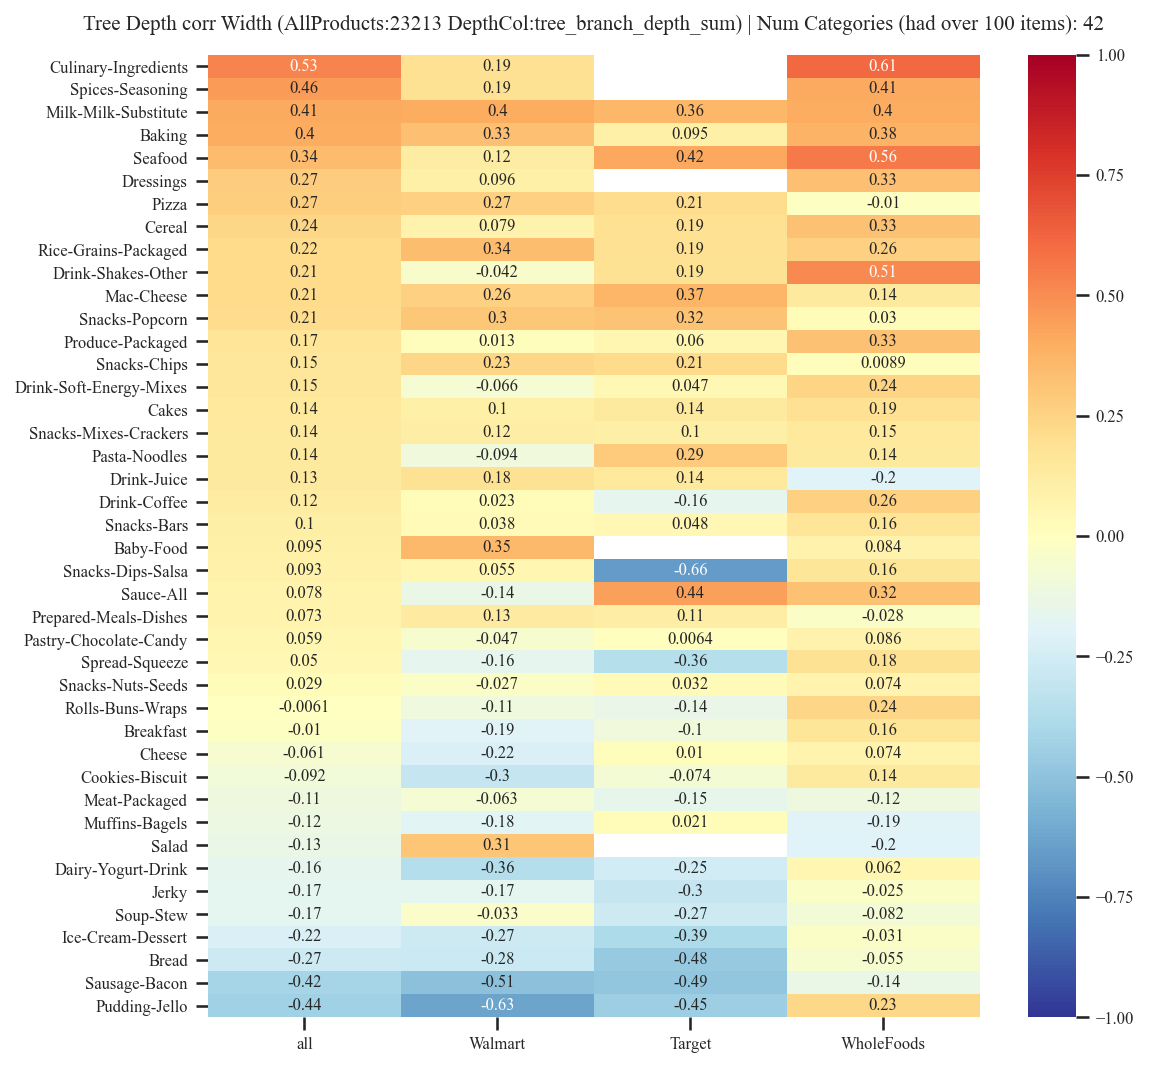

In [78]:
'''
THIS IS FOR ALL PRDOUCTS ~ 46593 REGARDLESS OF HAVING FPro or NOT
'''

res = grocery_base.plot_correlation_matrix(
    cat_corr_df=cat_tree_spects_corr_df, 
    filter_min_num_items_in_category=100,
    cols_heatmap = ['all'] + grocery_base.stores,
    title='Tree Depth corr Width (AllProducts:{} DepthCol:{})'.format(len(gdb_tree_spec_df), col_tree_depth), 
    figsize=(8.3, 8.5),font_size=8, add_count_items=False, vmin_vmax=(-1,1)
)
''

# PricePer Cal Category Corr-Map

In [79]:
[c for c in gdb_df.columns if 'pr' in c.lower()]

['FPro rank percentile',
 '12P FPro',
 '12P min_FPro',
 '12P std_FPro',
 'price',
 'price percal',
 'price pergram',
 'price_unit',
 'Protein',
 'Protein Conv',
 'proline',
 'proline Conv',
 'FPro_from_FDC',
 'f_FPro',
 'f_FPro_P',
 'f_FPro_src',
 'f_min_FPro',
 'f_std_FPro',
 'f_FPro_class']

In [80]:
column_cat = 'harmonized single category'

cat_df = pd.merge(
    gdb_df.groupby(column_cat).agg(count_selected_category = ('original_ID', np.size)).reset_index(),
    gdb_df[['original_ID', 'store', column_cat]],
    on=column_cat
)
len(gdb_conv_df)

24233

In [81]:
len(gdb_conv_df)
# sum(~gdb_conv_df['price'].isnull())

24233

In [82]:
column_cat = 'harmonized single category'
col_PricePerCal = 'price percal'

gdb_conv_PriceCal_df = gdb_conv_df.replace([np.inf, -np.inf], np.nan)
gdb_conv_PriceCal_df = gdb_conv_PriceCal_df[~gdb_conv_PriceCal_df[col_PricePerCal].isnull()]
gdb_conv_PriceCal_df = gdb_conv_PriceCal_df[gdb_conv_PriceCal_df['price percal'] < 0.1].reset_index(drop=True)
gdb_conv_PriceCal_df = gdb_conv_PriceCal_df[gdb_conv_PriceCal_df['package_weight'] < 1000].reset_index(drop=True)

gdb_conv_PriceCal_df = pd.merge(
    gdb_conv_PriceCal_df.groupby(column_cat).agg(count_have_PricePerCal_category = ('original_ID', np.size)).reset_index(),
    gdb_conv_PriceCal_df,
    on=column_cat
)

gdb_conv_PriceCal_df = gdb_conv_PriceCal_df.sort_values(by=column_cat).reset_index(drop=True)

len(gdb_conv_PriceCal_df)

17975

In [83]:
col_FPro = 'f_FPro'

cat_corr_df = []

for cat in gdb_conv_PriceCal_df[
        gdb_conv_PriceCal_df['count_have_PricePerCal_category'] > 0
    ][column_cat].unique():
    
    cat_df = gdb_conv_PriceCal_df[gdb_conv_PriceCal_df[column_cat] == cat]
    
    cat_corr_dict = {
        'cat': cat,
        'count items': len(cat_df)#cat_df['count_have_PricePerCal_category'].unique()[0]
        
    }
    cat_corr_df.append(cat_corr_dict)
    
    corr, corr_pval = stats.spearmanr(cat_df[col_FPro], cat_df[col_PricePerCal])
    cat_corr_dict['all'] = corr
    
    for store in grocery_base.stores:
        cat_store_df = cat_df[cat_df['store'] == store]
        cat_corr_dict[store] = None
        cat_corr_dict[store + ' count items'] = len(cat_store_df)
        
        if len(cat_store_df) > 10:
            corr, corr_pval = stats.spearmanr(cat_store_df[col_FPro], cat_store_df[col_PricePerCal])
            cat_corr_dict[store] = corr
            pass
        pass
    
#     break
    pass

cat_corr_df = pd.DataFrame(cat_corr_df).sort_values(by='all')

if False:
    cat_corr_df.to_csv('GDB PricePerCal correlation FPro.csv')

print(len(cat_corr_df))
cat_corr_df.head()

43


cat  count items       all   Walmart  Walmart count items  \
18  mac-cheese          191         -0.615950 -0.562416  71                    
13  drink-shakes-other  97          -0.546716 -0.296014  27                    
15  drink-tea           27          -0.534046 NaN        8                     
40  soup-stew           478         -0.523401 -0.404704  194                   
11  drink-coffee        109         -0.523374 -0.261525  44                    

      Target  Target count items  WholeFoods  WholeFoods count items  
18 -0.718839  62                 -0.760062    58                      
13 -0.654821  32                 -0.494359    38                      
15 NaN        8                  -0.251142    11                      
40 -0.633186  87                 -0.383087    197                     
11 -0.239669  18                 -0.407924    47

- LIST OF cmaps!! https://www.programmersought.com/article/15935826687/

''

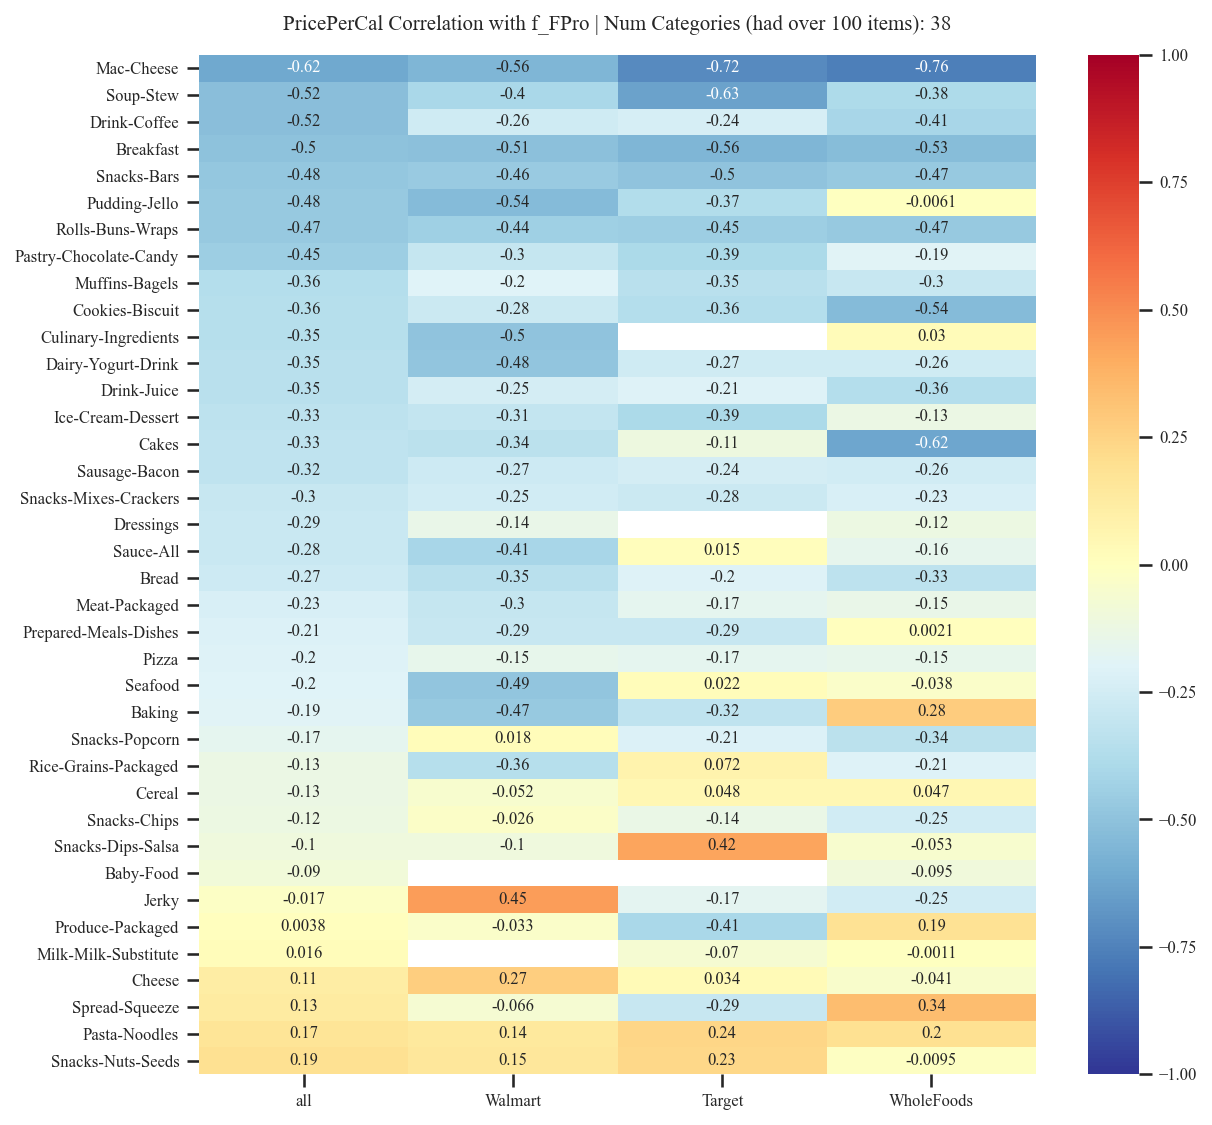

In [84]:
set_fonts()#font_size =12, font_scale

res = grocery_base.plot_correlation_matrix(
    cat_corr_df=cat_corr_df, 
    filter_min_num_items_in_category=100,
    cols_heatmap = ['all'] + grocery_base.stores,
    title='PricePerCal Correlation with ' + col_FPro, 
    figsize=(9, 9),
    font_size=8,
    add_count_items=False, vmin_vmax=(-1,1)
)
''

In [85]:
# [c for c in gdb_conv_PriceCal_df.columns if '12p' in c.lower()]
# # gdb_conv_PriceCal_df[['count_selected_category', 'count_products_category']]

# Distributions

## Price

In [86]:
sns.set(style="ticks", font="Times New Roman", font_scale=1.0)
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})

19345
limit_price_per_cal: 0.1
19139
limit_package_weight: 1000
17975
Num items with price: 17975 from 24233


[Text(0.5, 0, 'Package Weight'), Text(0, 0.5, 'Count')]

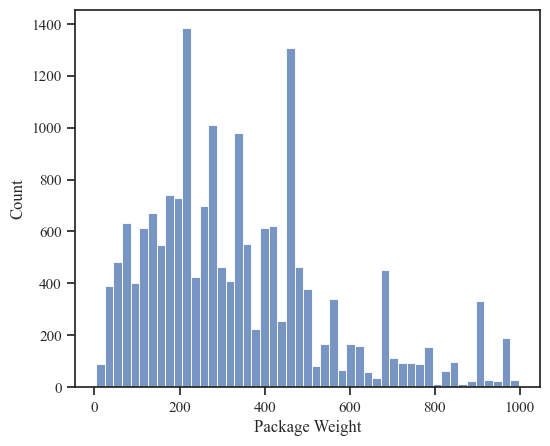

In [87]:
gdb_price_df = gdb_conv_df[(~gdb_conv_df['price percal'].isnull()) & (~gdb_conv_df['price percal'].isin([np.inf, -np.inf]))]

print(len(gdb_price_df))

limit_price_per_cal = [0.1, 0.15, 0.2][0]
print('limit_price_per_cal:', limit_price_per_cal)
gdb_price_df = gdb_price_df[gdb_price_df['price percal'] <limit_price_per_cal].reset_index(drop=True)
print(len(gdb_price_df))

limit_package_weight = [1000, 1500][0]
print('limit_package_weight:', limit_package_weight)
gdb_price_df = gdb_price_df[gdb_price_df['package_weight'] < limit_package_weight].reset_index(drop=True)
print(len(gdb_price_df))

print('Num items with price: {} from {}'.format(len(gdb_price_df), len(gdb_conv_df)))

# sns.displot(data=gdb_price_df, x=['price percal', 'price', 'package_weight'][2], kind="kde")

fig, axs = plt.subplots(1, figsize=(6, 5), dpi=100)
g=sns.histplot(data=gdb_price_df, x=['price percal', 'price', 'package_weight'][2], ax=axs)
g.set(xlabel='Package Weight', ylabel='Count')

[Text(0.5, 0, 'Package Price (Dollars)'), Text(0, 0.5, 'Count')]

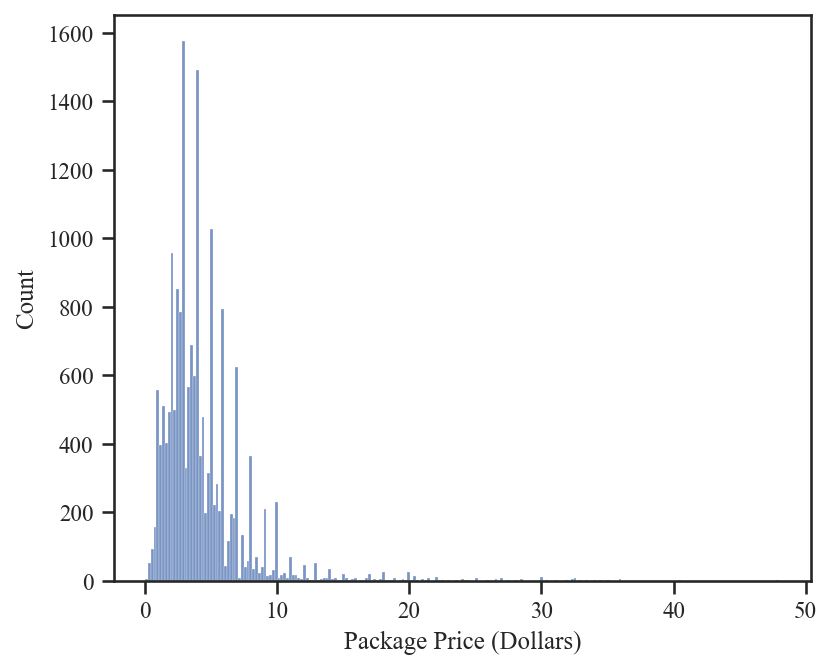

In [88]:
# sns.displot(data=gdb_price_df, x=['price percal', 'price', 'package_weight'][1], kind="kde")

fig, axs = plt.subplots(1, figsize=(6, 5), dpi=150)
sns.set(style="ticks", font="Times New Roman", font_scale=1.0)
sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})
g = sns.histplot(data=gdb_price_df, x=['price percal', 'price', 'package_weight'][1], ax=axs)
g.set(xlabel='Package Price (Dollars)', ylabel='Count')

In [89]:
[c for c in gdb_price_df.columns if 'price' in c]

['price', 'price percal', 'price pergram', 'price_unit']

[Text(0.5, 0, 'Price Per Calorie (Dollars)'), Text(0, 0.5, 'Count')]

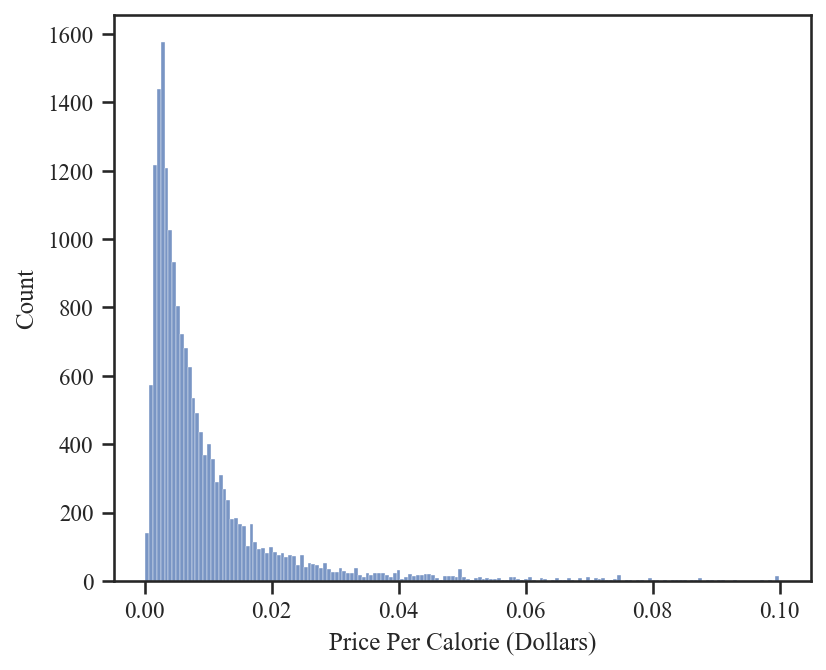

In [90]:
fig, axs = plt.subplots(1, figsize=(6, 5), dpi=150)
# soup dip , 'cakes', cereal

sns.set_style({'font.family': 'serif', 'font.serif': 'Times New Roman'})
sns.set(style="ticks", font="Times New Roman", font_scale=1.0)
g = sns.histplot(data=gdb_price_df, x='price percal', ax=axs)
g.set(xlabel='Price Per Calorie (Dollars)', ylabel='Count')

soup-stew        478
pasta-noodles    174
Name: harmonized single category, dtype: int64


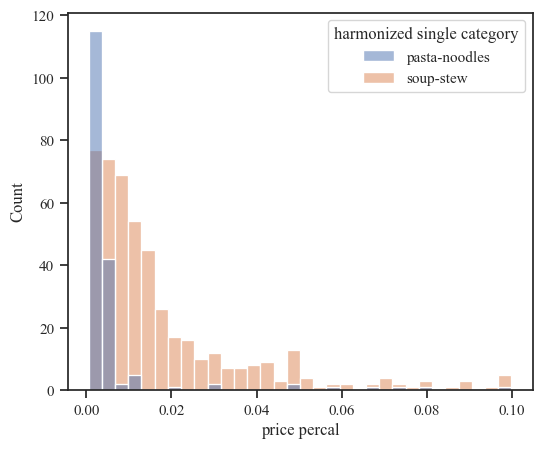

In [91]:
fig, axs = plt.subplots(1, figsize=(6, 5), dpi=100)
# soup dip , 'cakes', cereal

cats_isin = [
    ['soup', 'pizza', 'cakes'],
    ['soup-stew', 'pasta-noodles'], # rolls-buns-wraps
    ['pizza', 'cereal']
][1]
# print('cats_isin:', cats_isin)

col_x = ['price percal', 'price', 'calories'][0]

gdb_price_sel_df = gdb_price_df[gdb_price_df['harmonized single category'].isin(cats_isin)]

print(gdb_price_sel_df['harmonized single category'].value_counts())

if False:
    (
        sns.kdeplot(data=gdb_price_sel_df, x=col_x, hue='harmonized single category', ax=axs)
        .set(xlim=(0, None))
    )
else:
# sns.displot(data=gdb_price_sel_df, x='price percal', kind="kde", hue='harmonized single category')
    sns.histplot(data=gdb_price_sel_df, x=col_x, hue='harmonized single category', ax=axs)

In [92]:
gdb_price_sel_df[['original_ID', 'harmonized single category', 'url', 'name', 'store', 'price', 'package_weight', 'price percal', 'calories', 'package_calories']]

original_ID  \
7317   wf_star-anise-foods-garlic-pho-and-stir-fry-kit-45-oz-b00ipzgz9m   
7318   wf_whole-foods-market-organic-orzo-16-oz-b074jd6djq                
7319   wf_whole-foods-market-tricolor-linguine-16-oz-b07812m2cm           
7320   wf_nuovo-pasta-tricolor-mozzarella-herb-tortelloni-b079nmsc7b      
7321   wf_whole-foods-market-organic-ziti-0efc64                          
...                                          ...                          
17651  tg_79195256                                                        
17652  tg_14929007                                                        
17653  tg_17268964                                                        
17654  tg_17268959                                                        
17655  tg_15415186                                                        

      harmonized single category  \
7317   pasta-noodles               
7318   pasta-noodles               
7319   pasta-noodles               
7320   pasta-noodles               
7321   pasta-noodles               
...              ...               
17651  soup-stew                   
17652  soup-stew                   
17653  soup-stew                   
17654  soup-stew                   
17655  soup-stew                   

                                                                                                              url  \
7317   https://www.wholefoodsmarket.com/product/star-anise-foods-garlic-pho-and-stir-fry-kit-45-oz-b00ipzgz9m       
7318   https://www.wholefoodsmarket.com/product/whole-foods-market-organic-orzo-16-oz-b074jd6djq                    
7319   https://www.wholefoodsmarket.com/product/whole-foods-market-tricolor-linguine-16-oz-b07812m2cm               
7320   https://www.wholefoodsmarket.com/product/nuovo-pasta-tricolor-mozzarella-herb-tortelloni-b079nmsc7b          
7321   https://products.wholefoodsmarket.com/product/whole-foods-market-organic-ziti-0efc64                         
...                                                                                     ...                         
17651  https://www.target.com/p/mission-atomix-chips-chili-and-lime-8oz/-/A-79195256                                
17652  https://www.target.com/p/sabritones-chili-lime-wheat-puffs-4-5oz/-/A-14929007                                
17653  https://www.target.com/p/lotus-foods-gluten-free-and-vegan-jade-pearl-rice-ramen-2-8-oz/-/A-17268964         
17654  https://www.target.com/p/lotus-foods-gluten-free-and-vegan-millet-and-brown-rice-ramen-2-8-oz/-/A-17268959   
17655  https://www.target.com/p/annie-chun-39-s-vegan-noodle-bowl-korean-sweet-chili-8oz/-/A-15415186               

                                                                         name  \
7317   Garlic Pho And Stir Fry Kit, 4.5 oz                                      
7318   Organic Orzo, 16 oz                                                      
7319   Tricolor Linguine, 16 oz                                                 
7320   Tri-color Mozzarella & Herb Tortelloni                                   
7321   Organic Ziti, 16 oz                                                      
...                    ...                                                      
17651  Mission AtomiX Chips Chili and Lime  - 8oz                               
17652  Sabritones Chili Lime Wheat Puffs 4.5oz                                  
17653  Lotus Foods Gluten Free and Vegan Jade Pearl Rice Ramen 2.8-oz.          
17654  Lotus Foods Gluten Free and Vegan  Millet and Brown Rice Ramen 2.8-oz.   
17655  Annie Chun&#39;s Vegan Noodle Bowl Korean Sweet Chili - 8oz              

            store  price  package_weight  price percal    calories  \
7317   WholeFoods  4.79   127.57275       0.010824      346.875000   
7318   WholeFoods  1.99   453.59200       0.001228      357.142857   
7319   WholeFoods  4.99   453.59200       0.003896      282.352941   
7320   WholeFoods  9.99   510.29100       0.006751      290.000000  

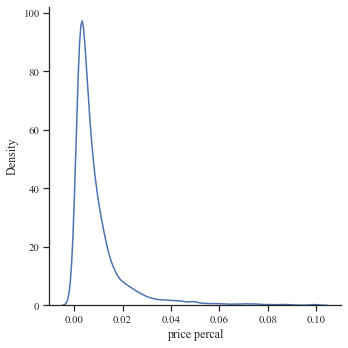

In [93]:
sns.displot(data=gdb_price_df, x='price percal', kind="kde")

In [94]:
gdb_price_df.sort_values('price percal', ascending=False)[['name', 'store', 'harmonized single category', 'price percal', 'url']][:50]

name  \
2947   Lemon Macaron 6ct, 3 oz                                                                          
2955   Jelly Filled Cookies, 0.26 lb                                                                    
2109   Petit Bonhomme Brie, 0.33 lb                                                                     
17191  Chicken Tortilla Bone Broth, 16 oz                                                               
6920   Healthy Ones Honey Smoked Turkey Breast - Deli Fresh Sliced - price per lb                       
6826   Peppered Salami - 5oz - Good &#38; Gather&#8482;                                                 
7089   Yoo-Hoo Chocolate Drink Family Pack, 6.5 fl oz, 32 count                                         
6816   Oscar Mayer Deli Fresh Mesquite Smoked Turkey Breast - 8oz                                       
6956   Oscar Mayer Deli Fresh Cracked Black Pepper Turkey - 8oz                                         
17207  Vegetable Stock, 32 fl oz                                                                        
17371  Organic Broth, Chicken - Low Sodium, 32 fl oz                                                    
17373  Organic Broth, Chicken, 32 fl oz                                                                 
12715  Primal Kitchen Roasted Garlic Marinara Sauce, 24 Oz                                              
15740  Yucatan, Foods Authentic Guacamole, 16 Oz.                                                       
7470   Osem Israeli (Pearl) Couscous - 8.8oz                                                            
5162   Cold Pressed Organic Green Devotion, 15.2 fl oz                                                  
16624  Multigrain Crackers 8oz - Archer Farms&#8482;                                                    
5386   Iberia Coconut Water with Pulp - 16.9 fl oz                                                      
17398  Great Value Organic Low Sodium Chicken Broth, 32 oz                                              
6843   Hormel Natural Choice Oven Roasted Turkey - 14oz                                                 
10522  Kidfresh Spaghetti Loops Frozen Bolognese - 7oz                                                  
17362  Organic Turkey Bone Broth, 24 fl oz                                                              
15405  Annie Chun&#39;s Roasted Seaweed Snacks Seaweed Crisps Original 1.27oz                           
3084   Chocolate Dipped Madeleines                                                                      
10769  Organic Fire Roasted Sweet Peppers, 16.2 oz                                                      
6440   Great Value Chicken Breast Tenderloins, 3 lb. (Frozen)                                           
5284   Ensure Original Nutritional Drink, Vanilla, 8 fl oz, 16 Count                                    
10113  Creminelli Sliced Prosciutto &#38; Mozzarella with Grissini - 2oz                                
15568  Zesty Black Bean Hummus, 7.5 oz                                                                  
17665  Organic Thyme, 0.28 oz                                                                           
17690  Organic Thyme, 0.78 oz                                                                           
6807   Oscar Mayer Deli Fresh Honey Smoked Turkey Breast - 9oz                                          
6811   Oscar Mayer Deli Fresh Sliced Oven Roasted Turkey Breast - 9oz                                   
6835   Oscar Mayer Deli Fresh Sliced Smoked Turkey Breast - 9oz                                         
17235  Beef Broth, 32 oz                                                                                
17265  Beef Bone Broth, 16.9 oz                                                                         
17238  Chipotle Beef Bone Broth, 16.9 oz                                                                
1076   Jimmy Dean Delights® Turkey Sausage, Egg White & Cheese Croissant Sandwiches, 4 Count (Frozen)   
40

In [95]:
print('''Items with missing price among''', len(gdb_conv_df), 'items that have nutrient profile.')
gdb_conv_df[~gdb_conv_df['price'].isnull()]['store'].value_counts()

Items with missing price among 24233 items that have nutrient profile.


Walmart       7952
Target        6314
WholeFoods    6294
Name: store, dtype: int64

In [96]:
print(sum(gdb_conv_df['price percal'].isnull()))

gdb_conv_df['price percal'].describe()

4888


count    19345.000000
mean     0.012817    
std      0.114393    
min      0.000013    
25%      0.002870    
50%      0.005535    
75%      0.010947    
max      14.695269   
Name: price percal, dtype: float64

<AxesSubplot:xlabel='f_FPro', ylabel='price percal'>

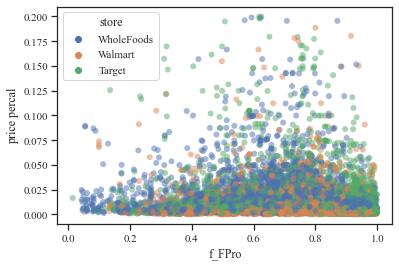

In [97]:
sns.scatterplot(data=gdb_conv_df[gdb_conv_df['price percal'] < 0.2], 
                x='f_FPro', y='price percal', hue='store', alpha=0.5, linewidth=0)

In [98]:
[c for c in gdb_df.columns if 'calories' in c.lower()]

['package_calories',
 'calories',
 'calories Conv',
 'fatCalories',
 'fatCalories Conv']

In [99]:
(
    gdb_conv_df[gdb_conv_df['f_FPro'] > 0.8]
    .sort_values('price percal')[['price percal', 'package_weight', 'calories', 'package_calories'] + cols_gdb_standard][:200]
)

price percal  package_weight     calories  package_calories  \
4422   0.000056      212.621250      250.000000   531.553125         
13663  0.000085      3458.639000     339.285714   11734.668036       
16792  0.000103      9071.847400     321.428571   29159.509500       
22442  0.000103      11657.323909    500.000000   58286.619545       
4480   0.000116      725.747792      533.333333   3870.654891        
23928  0.000124      4082.331330     333.333333   13607.771100       
1306   0.000154      283.495000      571.428571   1619.971429        
22438  0.000163      3855.535145     428.571429   16523.722050       
22112  0.000167      2551.455000     352.739907   9000.000000        
8198   0.000181      2381.358000     380.952381   9071.840000        
1838   0.000185      4984.980146     433.734940   21621.600635       
22025  0.000217      1814.368000     437.500000   7937.860000        
16861  0.000220      6803.885550     200.000000   13607.771100       
21833  0.000237      1814.368000     400.000000   7257.472000        
4449   0.000259      518.795850      653.846154   3392.126712        
4343   0.000263      219.708625      432.432432   950.091351         
1714   0.000267      11793.401620    317.073171   37393.712454       
816    0.000336      566.990000      461.538462   2616.876923        
7024   0.000338      3628.738960     71.729958    2602.892925        
11365  0.000363      198.446500      333.333333   661.488333         
2433   0.000377      1190.679000     1333.333333  15875.720000       
4479   0.000382      708.737500      472.222222   3346.815972        
4350   0.000382      708.737500      472.222222   3346.815972        
4298   0.000382      708.737500      472.222222   3346.815972        
17377  0.000387      340.194000      1200.000000  4082.328000        
4338   0.000395      708.737500      457.142857   3239.942857        
17932  0.000413      1564.892400     216.666667   3390.600200        
1842   0.000416      7438.914868     355.263158   26427.723873       
6345   0.000423      1080.000000     433.333333   4680.000000        
2290   0.000425      549.980300      388.888889   2138.812278        
16516  0.000429      1814.368000     431.372549   7826.685490        
11477  0.000434      283.495000      333.333333   944.983333         
345    0.000439      432.329875      395.348837   1709.211134        
5060   0.000446      907.184000      400.000000   3628.736000        
11339  0.000448      663.378300      336.363636   2231.363373        
8984   0.000451      205.533875      366.849504   754.000000         
4721   0.000451      518.795850      423.076923   2194.905519        
4187   0.000456      518.795850      423.076923   2194.905519        
11759  0.000456      283.495000      379.310345   1075.325862        
1845   0.000458      8482.177319     282.608696   23971.370684       
4918   0.000460      961.615824      450.000000   4327.271210        
4325   0.000463      510.291000      423.076923   2158.923462        
13770  0.000466      1587.572000     270.588235   4295.783059        
2352   0.000466      453.592000      444.444444   2015.964444        
4376   0.000468      515.960900      413.793103   2135.010621        
8976   0.000469      205.533875      352.739907   725.000000         
428    0.000475      240.970750      410.256410   988.597949         
8254   0.000476      2217.000000     329.896907   7313.814433        
15888  0.000477      7257.477920     51.724138    3753.867890        
2318   0.000490      510.291000      400.000000   2041.164000        
11454  0.000493      907.184000      576.923077   5233.753846        
306    0.000494      432.329875      627.906977   2714.629448        
16868  0.000494      7257.477920     77.777778    5644.705049        
2402   0.000496      538.640500      355.932203   1917.195000        
6442   0.000500      1080.000000     366.666667   3960.000000        
23526  0.000503      1020.582000     441.860465   4509.548372        
11469  0.000511  

<AxesSubplot:xlabel='12P min_FPro', ylabel='price pergram'>

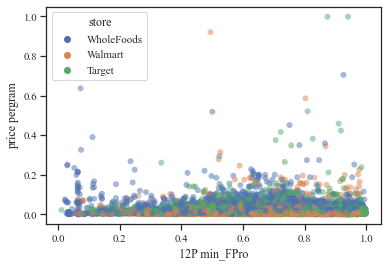

In [100]:
sns.scatterplot(data=gdb_conv_df[gdb_conv_df['price pergram'] < 1], 
                x='12P min_FPro', y='price pergram', hue='store', alpha=0.5, linewidth=0)

In [101]:
# data_df.groupby(['store']).agg({'f_FPro': np.min}).to_dict()['f_FPro']
# data_df

In [102]:
[c for c in gdb_df.columns if 'cat' in c.lower()]

['store category',
 'store category cleaned str',
 'harmonized category 2',
 'harmonized category 3',
 'harmonized single category',
 'store category cleaned',
 'harmonized category 1',
 'duplicate_IDs',
 'ignore_duplicate']

In [103]:
len(gdb_conv_df[gdb_conv_df[col_categories].isin(cats)])
sum(gdb_conv_df['isConverted'] == 0)
# 12P FPro
sum(gdb_conv_df['has10P'] == 0)

data_df = gdb_conv_df[gdb_conv_df[col_categories].isin(cats)].reset_index(drop=True)

data_df[['original_ID', 'store', 'name', col_categories]]

original_ID  \
0     wf_cascadian-farm-organic-french-vanilla-almond-granola-13-oz-b00em67nhg    
1     wf_bobs-red-mill-organic-steel-cut-oats-24-oz-b00ieitn4o                    
2     wf_natures-path-organic-dark-chocolate-macaroon-granola-115-oz-b00hvlbsh0   
3     wf_micheles-granola-lemon-pistachio-granola-12-oz-b082bv4bch                
4     wf_three-wishes-cereal-cinnamon-grain-free-cereal-86-oz-b07y5mmrjc          
...                                                                  ...          
5256  tg_79195256                                                                 
5257  tg_14929007                                                                 
5258  tg_17268964                                                                 
5259  tg_17268959                                                                 
5260  tg_15415186                                                                 

           store  \
0     WholeFoods   
1     WholeFoods   
2     WholeFoods   
3     WholeFoods   
4     WholeFoods   
...          ...   
5256  Target       
5257  Target       
5258  Target       
5259  Target       
5260  Target       

                                                                        name  \
0     Organic French Vanilla Almond Granola, 13 oz                             
1     Organic Steel Cut Oats, 24 oz                                            
2     Dark Chocolate Macaroon Granola, 11.5 oz                                 
3     Lemon Pistachio Granola, 12 oz                                           
4     Cinnamon Grain Free Cereal, 8.6 oz                                       
...                                  ...                                       
5256  Mission AtomiX Chips Chili and Lime  - 8oz                               
5257  Sabritones Chili Lime Wheat Puffs 4.5oz                                  
5258  Lotus Foods Gluten Free and Vegan Jade Pearl Rice Ramen 2.8-oz.          
5259  Lotus Foods Gluten Free and Vegan  Millet and Brown Rice Ramen 2.8-oz.   
5260  Annie Chun&#39;s Vegan Noodle Bowl Korean Sweet Chili - 8oz              

     harmonized single category  
0     cereal                     
1     cereal                     
2     cereal                     
3     cereal                     
4     cereal                     
...      ...                     
5256  soup-stew                  
5257  soup-stew                  
5258  soup-stew                  
5259  soup-stew                  
5260  soup-stew                  

[5261 rows x 4 columns]

In [104]:
# gdb_conv_df[col_categories].value_counts()
# gdb_conv_df[[col_categories, 'f_FPro', 'price percal', 'store']].to_csv('price_per_cal.csv')

In [105]:
col_categories

'harmonized single category'

selected_cat: milk-milk-substitute
len BEFORE filtering num records in each bin/store: 170
len AFTER filtering num records in each bin/store: 160
milk-milk-substitute | corr: -0.074 num product: 164/402
Predicted:  0.7  FPro -> -4.665339092464685
Predicted:  1.0  FPro -> -4.60703125978466


''

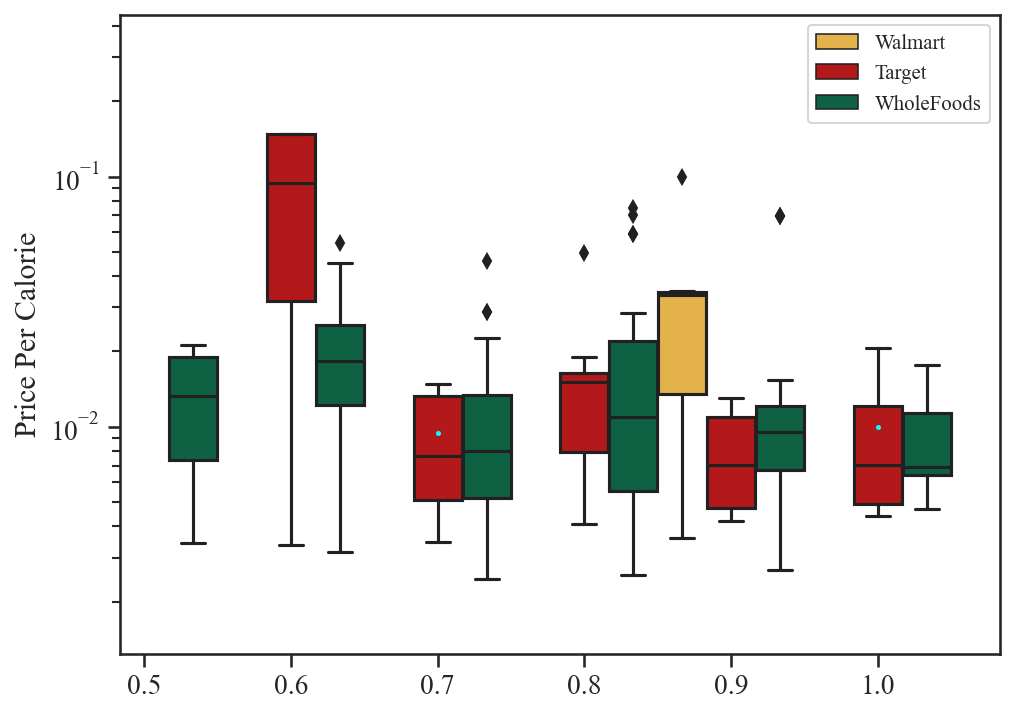

In [106]:
set_fonts()

selected_cat = [
    'soup-stew', 'cereal', 'milk-milk-substitute', 'cakes', 'pastry-chocolate-candy',
    'breakfast', 'snacks-popcorn', 'ice-cream-dessert',
    'pizza', 'snacks-bars', 'cheese', 
    'dairy-yogurt-drink', 'cookies-biscuit', 'pasta-noodles'
][2]
print('selected_cat:', selected_cat)

data_df = gdb_conv_df[gdb_conv_df[col_categories] == selected_cat].reset_index(drop=True)

FPro_bin_size = 0.1

# data_df['price percal'] = data_df['price percal'].apply(np.log)

p_res = grocery_base.plot_price_per_cal(
    n_label_x_pad={'Walmart': -0.3, 'Target': 0.05, 'WholeFoods': +0.35},
    figsize=(7, 5), # for figures
#     figsize=(9, 5), # for pasta and noodles
    dpi=150, col_FPro='f_FPro', col_yaxis='price percal',
    FPro_bin_size=FPro_bin_size, store_compare_data_df=data_df, remove_legend=False,
    min_FPro_filter= 0.4, # for figures
#     min_FPro_filter= 0.0, # for pasta and noodles
    title=selected_cat, width_box=1.0,
    min_num_records_in_each_store_bin=4, print_n_on_plot=False, verbose=False
)

def draw_pred_point(FPro, cat):  
#     USE FILE "price_reg.xlsx"
    coef_noTransformation = {'cereal': -0.000955424259041369,'soup-stew':-0.0491247752455035, 'milk-milk-substitute': 0.00369285247256148}
    const_noTransformation = {'cereal': 0.0040942003729359,'soup-stew':0.0524416497358708, 'milk-milk-substitute': 0.00826909109620743}
#     USE FILE "price_reg_log_log.xlsx"
    coef = {'cereal': -0.122714987911472,'soup-stew':-2.91505682859921, 'milk-milk-substitute': 0.163476110870409}
    const = {'cereal': -5.85759456667673,'soup-stew':-5.28811179989426, 'milk-milk-substitute': -4.60703125978466}
    
    if cat not in coef:
        print('[ERROR] DONT HAVE coef to draw a point on the fitted line for cat:', cat)
        return

    FPro_to_box_x = {0.5:1, 0.6:2, 0.7:3, 0.8:4, 0.9:5, 1.0:6}

    pred_price = coef[cat] * np.log(FPro) + const[cat]
    print('Predicted: ', FPro, ' FPro ->', pred_price)

    line_point = (FPro_to_box_x[FPro], np.exp(pred_price))

    plt.scatter(line_point[0], line_point[1], marker='o', s=2, color='aqua')
    
    return line_point

draw_pred_point(FPro=0.7, cat=selected_cat)
draw_pred_point(FPro=1.0, cat=selected_cat)

plt.savefig('output/fig3_D.pdf', bbox_inches='tight')

''

In [107]:
cat = 'cereal'

coef = {'cereal': -0.000955424259041369}
const = {'cereal': 0.0040942003729359}

FPro = 0.5
FPro_to_box_x = {0.5:1, 0.6:2, 0.7:3, 0.8:4, 0.9:5, 1.0:6}

pred_price = coef[cat] * FPro + const[cat]

(FPro_to_box_x[FPro], pred_price)

(1, 0.0036164882434152157)

## Price Change from Unprocessed to Ultra-Processed

In [108]:
esitmate_perc_change_apply_log = False

In [109]:
# grocery_base.normalizeBetweenTwoRanges(val=0.55, minVal=0.35, maxVal=0.98, newMin=0, newMax=1)
# gdb_price_cat_df[['harmonized single category', 'name', 'store', 'brand', 'f_FPro', 'f_FPro Standardized']]

In [110]:
def cal_price_change_df(col_FPro, col_price):
    col_price_type = ['price percal', 'price'][0]
    
    price_change_df = []

    target_perc = 10
    rlm_weight_cut_off = [None, 1.0][0]
    
    print('col_FPro:', col_FPro)
    print('col_price_type:', col_price_type)
    print('col_price:', col_price)

    for cat in ['ALL'] +  list(gdb_conv_df[col_categories].unique()):

#         if cat != 'milk-milk-substitute':
#             continue

        if cat == 'ALL':
            cat_price_df = gdb_conv_df
        else:
            cat_price_df = gdb_conv_df[gdb_conv_df[col_categories] == cat]

        gdb_price_cat_df = (
            cat_price_df[
    #             (gdb_conv_df[col_categories] == cat) & 
                (~cat_price_df[col_price_type].isnull())
            ]
            .sort_values(by='f_FPro', ascending=True)
            .reset_index(drop=True)
        )

        gdb_price_cat_df['f_FPro Standardized'] = gdb_price_cat_df['f_FPro'].apply(
            lambda fpro: grocery_base.normalizeBetweenTwoRanges(
                val=fpro, 
                minVal=gdb_price_cat_df['f_FPro'].min(), 
                maxVal=gdb_price_cat_df['f_FPro'].max(), 
                newMin=0,
                newMax=1
            )
        )
        
        gdb_price_cat_df[col_price_type + ' Standardized'] = gdb_price_cat_df[col_price_type].apply(
            lambda fpro: grocery_base.normalizeBetweenTwoRanges(
                val=fpro, 
                minVal=gdb_price_cat_df[col_price_type].min(), 
                maxVal=gdb_price_cat_df[col_price_type].max(), 
                newMin=0,
                newMax=1
            )
        )

        ''''''
        x_vals = gdb_price_cat_df[col_FPro]
        X = np.c_[np.ones(len(x_vals)), x_vals]

        y = gdb_price_cat_df[col_price]

        rlm_model = sm.RLM(y, X, sm.robust.norms.HuberT())

        rlm_results = rlm_model.fit()

        gdb_price_cat_df['rlm weights'] = rlm_results.weights

        num_outliers = sum(gdb_price_cat_df['rlm weights'] < 1.0)

        if False:
            print('cat: {} num: {} outliers: {}'.format(
                cat,
                len(gdb_price_cat_df),
                num_outliers
            ))

    #     gdb_price_cat_df = gdb_price_cat_df[gdb_price_cat_df['rlm weights'] >= rlm_weight_cut_off]
        
        # USE RLM weight for sure, otherwise the effect is driven by outliers...
        if True:
            gdb_price_cat_df[col_price] = gdb_price_cat_df[col_price] * gdb_price_cat_df['rlm weights']

        ''''''

        num_perc = int(np.ceil((len(gdb_price_cat_df) * target_perc) / 100))

        least_fpro_df = gdb_price_cat_df.head(num_perc)
        highest_fpro_df = gdb_price_cat_df.tail(num_perc)

        least_FPro_price_avg = least_fpro_df[col_price].mean()
        highest_FPro_price_avg = highest_fpro_df[col_price].mean()

        price_change_df.append({
                'cat': cat,
                'count items': len(gdb_price_cat_df),
                'RLM weight min': rlm_weight_cut_off,
                'RLM num outliers (weight < 1)': num_outliers,
                'RLM coef': rlm_results.params[1],
                'RLM pvalue': round(rlm_results.pvalues[1], 6),
                'target_perc': target_perc,
                'num items target_perc': num_perc,
                'least FPro avg': least_fpro_df[col_FPro].mean(),
                'highest FPro avg': highest_fpro_df[col_FPro].mean(),
                'least price avg': least_FPro_price_avg,
                'highest prcie avg': highest_FPro_price_avg,
                'price perc change least to highest FPro': ((highest_FPro_price_avg - least_FPro_price_avg) / least_FPro_price_avg) * 100
            }
        )

    #     break
        pass
    
#     gdb_conv_df[col_categories].unique()
#     gdb_price_cat_df[[col_categories, 'store', 'name', 'brand', col_price, col_FPro]].tail(num_perc)

    price_change_df = pd.DataFrame(price_change_df).sort_values('price perc change least to highest FPro').reset_index(drop=True)
    
    return price_change_df

# price_change_df = cal_price_change_df(col_FPro='f_FPro Standardized')
price_change_df = cal_price_change_df(col_FPro='f_FPro', col_price='price percal')
price_change_df[price_change_df['count items'] > 0]
# price_change_df[price_change_df['cat'] == 'milk-milk-substitute']

col_FPro: f_FPro
col_price_type: price percal
col_price: price percal


cat  count items RLM weight min  \
0   drink-shakes-other       229          None            
1   spices-seasoning         107          None            
2   drink-coffee             155          None            
3   pudding-jello            201          None            
4   soup-stew                505          None            
5   culinary-ingredients     141          None            
6   sauce-all                517          None            
7   drink-tea                45           None            
8   breakfast                246          None            
9   muffins-bagels           199          None            
10  salad                    88           None            
11  drink-juice              296          None            
12  drink-soft-energy-mixes  88           None            
13  snacks-bars              1125         None            
14  mac-cheese               199          None            
15  pastry-chocolate-candy   1310         None            
16  snacks-mixes-crackers    938          None            
17  ice-cream-dessert        645          None            
18  ALL                      19345        None            
19  cookies-biscuit          961          None            
20  bread                    537          None            
21  sausage-bacon            392          None            
22  cakes                    323          None            
23  rolls-buns-wraps         515          None            
24  snacks-chips             864          None            
25  meat-packaged            744          None            
26  pizza                    337          None            
27  dairy-yogurt-drink       682          None            
28  prepared-meals-dishes    1627         None            
29  seafood                  328          None            
30  snacks-dips-salsa        282          None            
31  rice-grains-packaged     114          None            
32  dressings                435          None            
33  baby-food                115          None            
34  cereal                   659          None            
35  produce-packaged         947          None            
36  snacks-popcorn           184          None            
37  baking                   324          None            
38  cheese                   783          None            
39  jerky                    208          None            
40  milk-milk-substitute     240          None            
41  spread-squeeze           236          None            
42  snacks-nuts-seeds        296          None            
43  pasta-noodles            178          None            

    RLM num outliers (weight < 1)  RLM coef  RLM pvalue  target_perc  \
0   59                            -0.031803  0.000000    10            
1   26                            -0.033220  0.000000    10            
2   45                            -0.058424  0.000000    10            
3   58                            -0.029053  0.000000    10            
4   121                           -0.051192  0.000000    10            
5   33                            -0.002558  0.019873    10            
6   80                            -0.013848  0.000000    10            
7   9                             -0.076848  0.000000    10            
8   50                            -0.019419  0.000000    10            
9   42                            -0.024346  0.000000    10            
10  21                            -0.046952  0.000000    10            
11  80                            -0.018368  0.000000    10            
12  16                            -0.017934  0.015978    10            
13  197                           -0.013125  0.000000    10            
14  46                            -0.023767  0.000000    10            
15  283                           -0.011431  0.000000    10            
16  177                           -0.015431  0.000000    10            
17  141                           -0.014730  0.000000    10            


In [111]:
price_change_standardized_df = cal_price_change_df(col_FPro='f_FPro Standardized', col_price='price percal Standardized')

col_FPro: f_FPro Standardized
col_price_type: price percal
col_price: price percal Standardized


In [112]:
price_change_both_df = pd.merge(
    price_change_df,
    price_change_standardized_df[['cat', 'least FPro avg', 'highest FPro avg', 'least price avg',
                                 'highest prcie avg', 'price perc change least to highest FPro']].rename(columns={
        'least FPro avg': 'least FPro avg Standardized',
        'highest FPro avg': 'highest FPro Standardized',
        'least price avg': 'least price avg Standardized',
        'highest prcie avg': 'highest prcie avg Standardized',
        'price perc change least to highest FPro': 'price perc change least to highest FPro Standardized'
    }),
    on='cat'
).sort_values('price perc change least to highest FPro Standardized').reset_index(drop=True)

price_change_both_df[price_change_both_df['count items'] > 0]

cat  count items RLM weight min  \
0   pudding-jello            201          None            
1   drink-shakes-other       229          None            
2   culinary-ingredients     141          None            
3   drink-coffee             155          None            
4   spices-seasoning         107          None            
5   soup-stew                505          None            
6   salad                    88           None            
7   muffins-bagels           199          None            
8   sauce-all                517          None            
9   drink-tea                45           None            
10  breakfast                246          None            
11  drink-soft-energy-mixes  88           None            
12  mac-cheese               199          None            
13  snacks-bars              1125         None            
14  drink-juice              296          None            
15  pastry-chocolate-candy   1310         None            
16  snacks-mixes-crackers    938          None            
17  ice-cream-dessert        645          None            
18  ALL                      19345        None            
19  cookies-biscuit          961          None            
20  bread                    537          None            
21  sausage-bacon            392          None            
22  cakes                    323          None            
23  pizza                    337          None            
24  rolls-buns-wraps         515          None            
25  meat-packaged            744          None            
26  snacks-chips             864          None            
27  dairy-yogurt-drink       682          None            
28  prepared-meals-dishes    1627         None            
29  seafood                  328          None            
30  rice-grains-packaged     114          None            
31  snacks-dips-salsa        282          None            
32  dressings                435          None            
33  baby-food                115          None            
34  cereal                   659          None            
35  produce-packaged         947          None            
36  snacks-popcorn           184          None            
37  baking                   324          None            
38  cheese                   783          None            
39  jerky                    208          None            
40  milk-milk-substitute     240          None            
41  spread-squeeze           236          None            
42  snacks-nuts-seeds        296          None            
43  pasta-noodles            178          None            

    RLM num outliers (weight < 1)  RLM coef  RLM pvalue  target_perc  \
0   58                            -0.029053  0.000000    10            
1   59                            -0.031803  0.000000    10            
2   33                            -0.002558  0.019873    10            
3   45                            -0.058424  0.000000    10            
4   26                            -0.033220  0.000000    10            
5   121                           -0.051192  0.000000    10            
6   21                            -0.046952  0.000000    10            
7   42                            -0.024346  0.000000    10            
8   80                            -0.013848  0.000000    10            
9   9                             -0.076848  0.000000    10            
10  50                            -0.019419  0.000000    10            
11  16                            -0.017934  0.015978    10            
12  46                            -0.023767  0.000000    10            
13  197                           -0.013125  0.000000    10            
14  80                            -0.018368  0.000000    10            
15  283                           -0.011431  0.000000    10            
16  177                           -0.015431  0.000000    10            
17  141                           -0.014730  0.000000    10            


esitmate_perc_change_apply_log: False


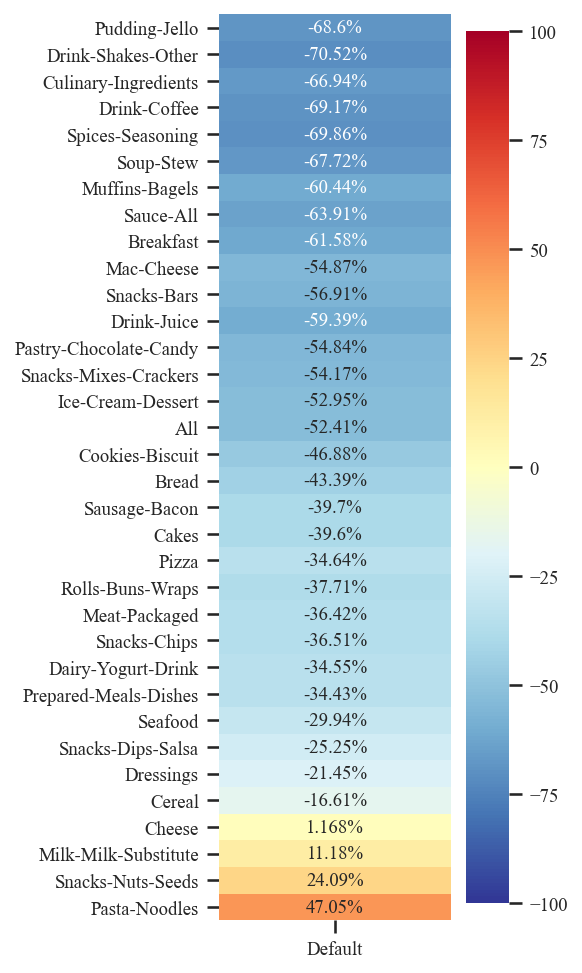

In [113]:
print('esitmate_perc_change_apply_log:', esitmate_perc_change_apply_log)

col_plot = 'price perc change least to highest FPro'
col_plot_standardized = 'price perc change least to highest FPro Standardized'

price_change_results_df = price_change_both_df.copy()
# reg_results_c.loc[reg_results_c['RLM pvalue'] > 0.05, col_plot] = None

price_change_results_df = price_change_results_df[  
#     (~price_change_results_df['cat'].isin(['pasta-noodles'])) & 
    (price_change_results_df['RLM pvalue'] < 0.05)
].reset_index(drop=True)

res = grocery_base.plot_correlation_matrix(
    cat_corr_df=price_change_results_df, 
    filter_min_num_items_in_category=100,
    cols_heatmap = [col_plot], #, 'OLS'
#     cols_heatmap = [col_plot_standardized, col_plot], #, 'OLS'
#     title=f'PricePerCal ~ FPro | FPro min: {fpro_min}\nRegression Ordinary Least Squares & Robust Linear Model', 
    title=None, # to hide title
    figsize=(2.5, 8), # 1.5
    font_size=9,
    add_count_items=False, 
    vmin_vmax=(-100, 100),
#     xticklabels=['Standardized', 'Default'],
    xticklabels=['Default'],
#     vmin_vmax=(None, None)
    fmt='.4g',
    export_path='output/fig3_E.pdf'
)

g = res['g']
cat_corr_df = res['cat_corr_df']

# the null ones (not sig) wont have a text in g.axes.texts
# cat_corr_df = cat_corr_df[cat_corr_df['RLM pval stars'] != ''].reset_index(drop=True)

for i in range(len(g.axes.texts)):
    g.axes.texts[i]._text += '%'# + cat_corr_df['RLM pval stars'].values[i]
    pass

## Fit PricePerCal ~ FPro

standardized: 

$$$$$$$$$$$$$$$[ALL] price ~ FPro --> coef: -0.8148 RLM: -0.9487x + -5.4381 (pval: 0.0) | count: 19345


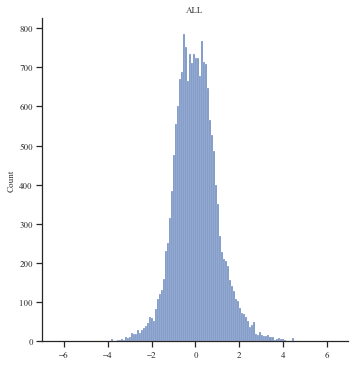


$$$$$$$$$$$$$$$[baby-food] price ~ FPro --> coef: -0.1489 RLM: -0.1418x + -3.7860 (pval: 0.36821656329890073) | count: 115


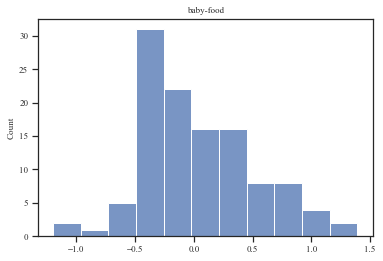


$$$$$$$$$$$$$$$[baking] price ~ FPro --> coef: 0.1956 RLM: 0.1014x + -5.9606 (pval: 0.454136563993942) | count: 324


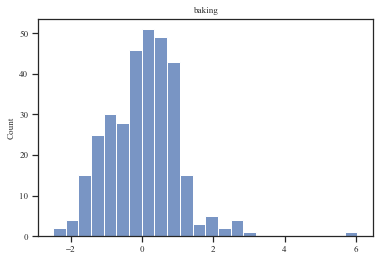


$$$$$$$$$$$$$$$[bread] price ~ FPro --> coef: -1.7774 RLM: -2.0160x + -5.9180 (pval: 1.510804996456691e-11) | count: 537


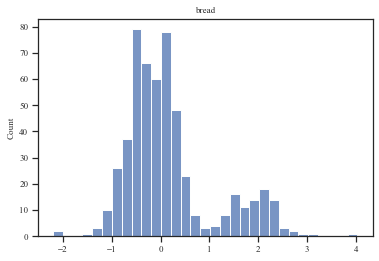


$$$$$$$$$$$$$$$[breakfast] price ~ FPro --> coef: -2.5189 RLM: -2.8592x + -5.8965 (pval: 2.7803680900773744e-23) | count: 246


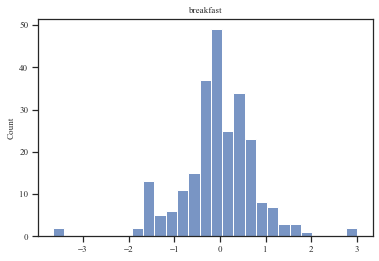


$$$$$$$$$$$$$$$[cakes] price ~ FPro --> coef: -3.7248 RLM: -4.8078x + -5.9640 (pval: 2.1938536854372162e-30) | count: 323


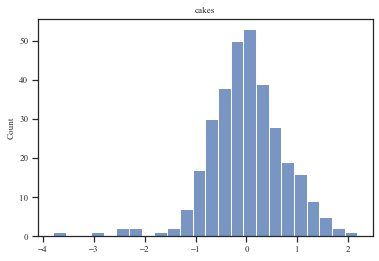


$$$$$$$$$$$$$$$[cereal] price ~ FPro --> coef: -0.1298 RLM: -0.1164x + -5.8495 (pval: 0.19813793233013255) | count: 659


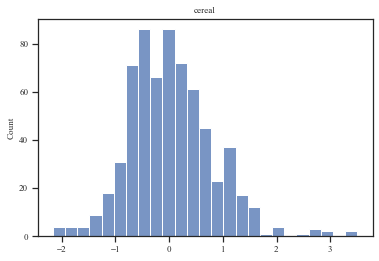


$$$$$$$$$$$$$$$[cheese] price ~ FPro --> coef: 0.2184 RLM: 0.3706x + -5.0435 (pval: 0.01670350455461223) | count: 783


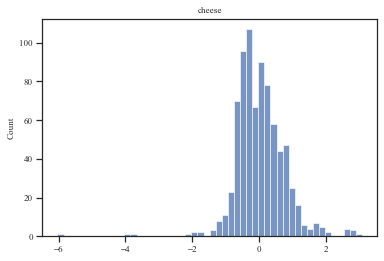


$$$$$$$$$$$$$$$[cookies-biscuit] price ~ FPro --> coef: -4.7981 RLM: -4.2619x + -6.0182 (pval: 1.882741483067306e-68) | count: 961


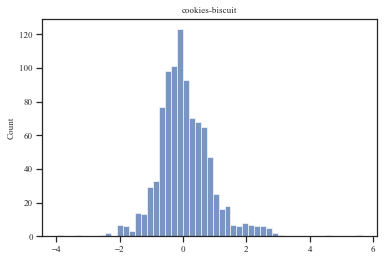


$$$$$$$$$$$$$$$[culinary-ingredients] price ~ FPro --> coef: -0.4685 RLM: -0.6910x + -6.3528 (pval: 0.018026150560611947) | count: 141


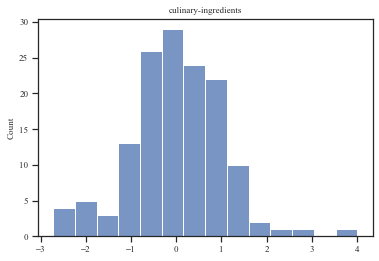


$$$$$$$$$$$$$$$[dairy-yogurt-drink] price ~ FPro --> coef: -0.3426 RLM: -0.3728x + -4.8162 (pval: 6.919449221772787e-10) | count: 682


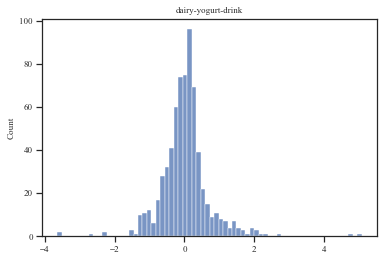


$$$$$$$$$$$$$$$[dressings] price ~ FPro --> coef: -0.5969 RLM: -0.7045x + -5.5474 (pval: 0.05721918498587) | count: 435


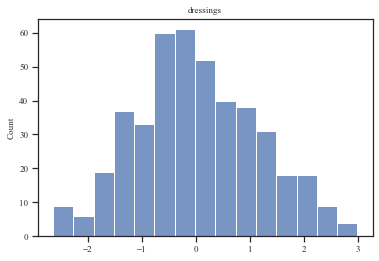


$$$$$$$$$$$$$$$[drink-coffee] price ~ FPro --> coef: -2.3634 RLM: -2.3657x + -5.3187 (pval: 1.3355980280720028e-13) | count: 155


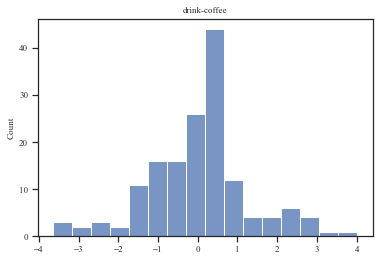


$$$$$$$$$$$$$$$[drink-juice] price ~ FPro --> coef: -1.2635 RLM: -1.4714x + -5.3690 (pval: 7.707365548381548e-14) | count: 296


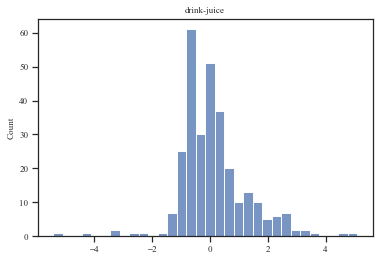


$$$$$$$$$$$$$$$[drink-shakes-other] price ~ FPro --> coef: -2.2615 RLM: -2.3388x + -5.2750 (pval: 2.5408625185353153e-16) | count: 229


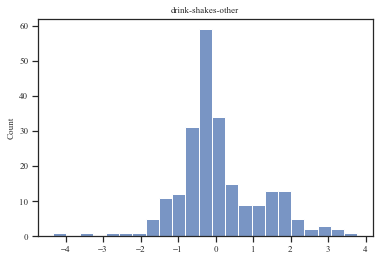


$$$$$$$$$$$$$$$[drink-soft-energy-mixes] price ~ FPro --> coef: -1.2395 RLM: -1.3160x + -4.8912 (pval: 0.005716051150172941) | count: 88


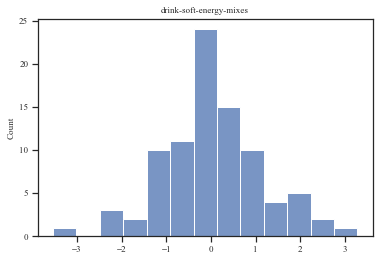


$$$$$$$$$$$$$$$[drink-tea] price ~ FPro --> coef: -4.4250 RLM: -4.3508x + -5.9413 (pval: 1.1370215108952125e-20) | count: 45


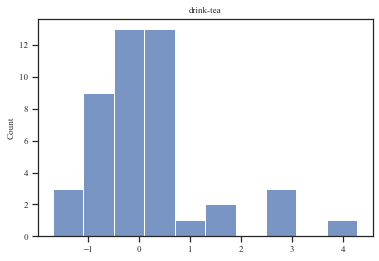


$$$$$$$$$$$$$$$[ice-cream-dessert] price ~ FPro --> coef: -2.2048 RLM: -2.5365x + -5.9451 (pval: 3.019807993209923e-29) | count: 645


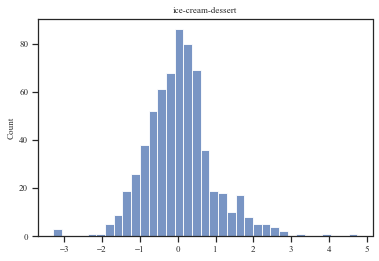


$$$$$$$$$$$$$$$[jerky] price ~ FPro --> coef: 2.1603 RLM: 1.4900x + -3.1708 (pval: 0.09006580296602723) | count: 208


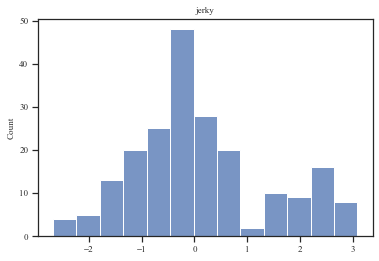


$$$$$$$$$$$$$$$[mac-cheese] price ~ FPro --> coef: -3.1964 RLM: -3.3862x + -5.8587 (pval: 1.9474655323873772e-25) | count: 199


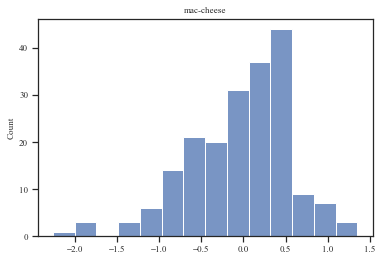


$$$$$$$$$$$$$$$[meat-packaged] price ~ FPro --> coef: -0.3430 RLM: -0.3672x + -4.6746 (pval: 0.00014963399767617164) | count: 744


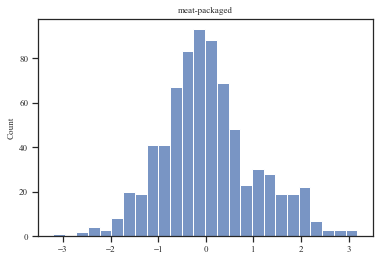


$$$$$$$$$$$$$$$[milk-milk-substitute] price ~ FPro --> coef: 0.1812 RLM: 0.1635x + -4.6070 (pval: 0.007814876655692488) | count: 240


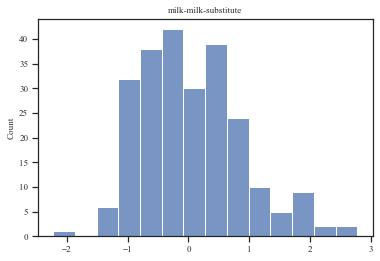


$$$$$$$$$$$$$$$[muffins-bagels] price ~ FPro --> coef: -2.9268 RLM: -3.2548x + -5.8497 (pval: 1.005301749005629e-12) | count: 199


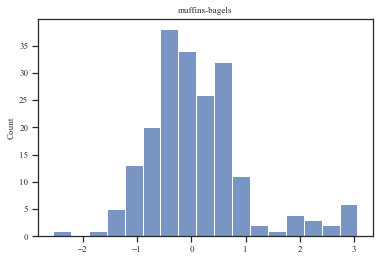


$$$$$$$$$$$$$$$[pasta-noodles] price ~ FPro --> coef: 0.7864 RLM: 0.6113x + -5.5066 (pval: 0.0003211037455881376) | count: 178


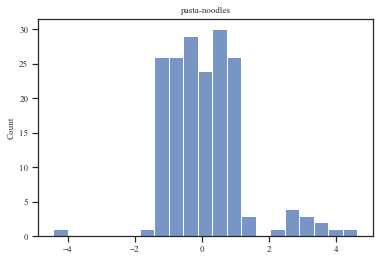


$$$$$$$$$$$$$$$[pastry-chocolate-candy] price ~ FPro --> coef: -1.4597 RLM: -1.5184x + -5.8077 (pval: 3.7033976294847825e-56) | count: 1310


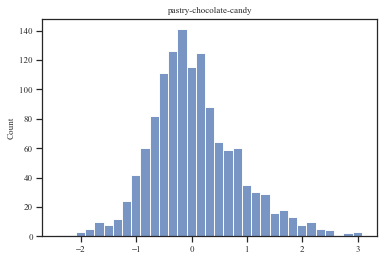


$$$$$$$$$$$$$$$[pizza] price ~ FPro --> coef: -1.1721 RLM: -1.3846x + -5.5092 (pval: 4.00563754757376e-05) | count: 337


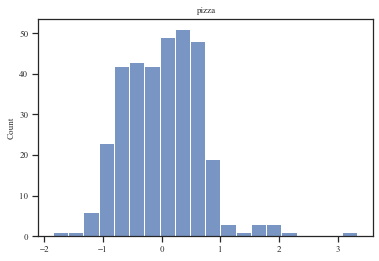


$$$$$$$$$$$$$$$[prepared-meals-dishes] price ~ FPro --> coef: -0.0925 RLM: -0.4260x + -4.9747 (pval: 3.212112938542652e-05) | count: 1627


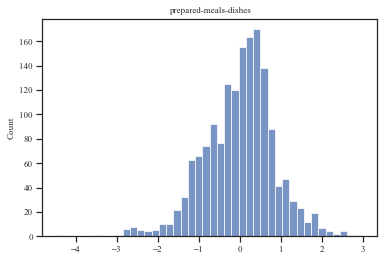


$$$$$$$$$$$$$$$[produce-packaged] price ~ FPro --> coef: 0.1469 RLM: 0.1596x + -4.5477 (pval: 0.16205395146159318) | count: 947


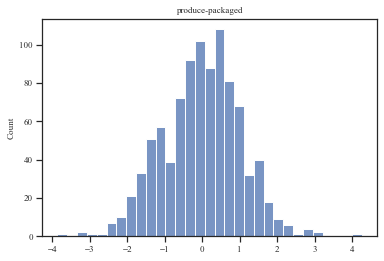


$$$$$$$$$$$$$$$[pudding-jello] price ~ FPro --> coef: -3.0866 RLM: -2.9627x + -5.9032 (pval: 9.076395004633216e-26) | count: 201


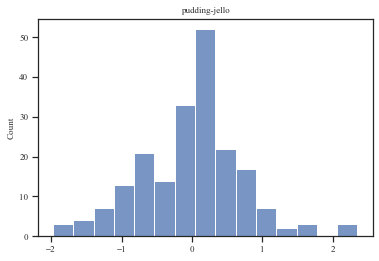


$$$$$$$$$$$$$$$[rice-grains-packaged] price ~ FPro --> coef: -0.1038 RLM: -0.1399x + -5.1656 (pval: 0.2976880809156901) | count: 114


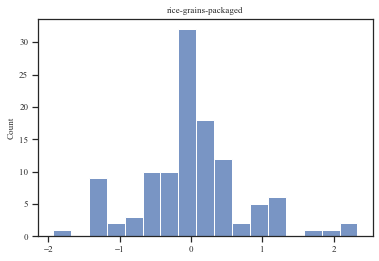


$$$$$$$$$$$$$$$[rolls-buns-wraps] price ~ FPro --> coef: -1.4751 RLM: -1.7853x + -5.7392 (pval: 5.406907895601027e-30) | count: 515


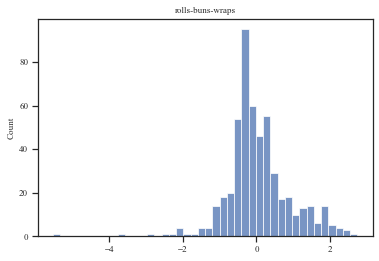


$$$$$$$$$$$$$$$[salad] price ~ FPro --> coef: -1.8468 RLM: -1.7836x + -5.2347 (pval: 7.813135049920036e-16) | count: 88


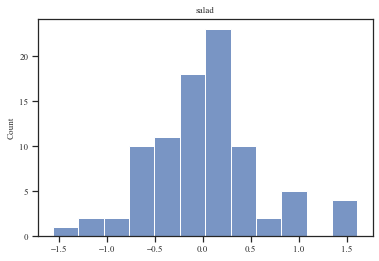


$$$$$$$$$$$$$$$[sauce-all] price ~ FPro --> coef: -1.2952 RLM: -1.2184x + -5.1961 (pval: 1.1104588993568952e-07) | count: 517


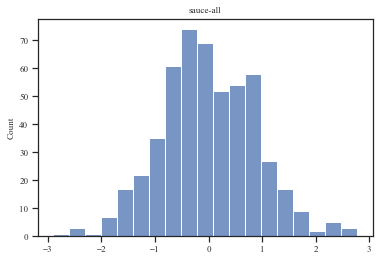


$$$$$$$$$$$$$$$[sausage-bacon] price ~ FPro --> coef: -1.4015 RLM: -1.4890x + -5.5894 (pval: 1.3712792360229962e-11) | count: 392


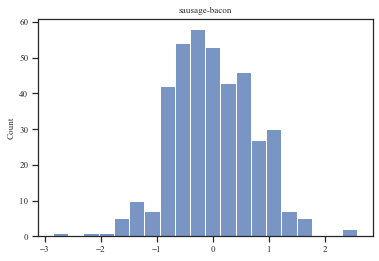


$$$$$$$$$$$$$$$[seafood] price ~ FPro --> coef: -0.4828 RLM: -0.4003x + -4.4905 (pval: 1.6524998761973343e-05) | count: 328


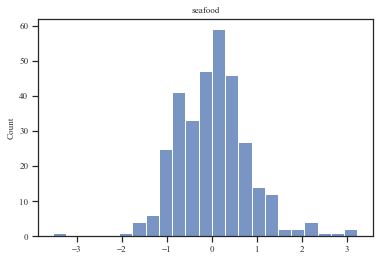


$$$$$$$$$$$$$$$[snacks-bars] price ~ FPro --> coef: -1.3102 RLM: -1.3065x + -5.2663 (pval: 3.0967760932321277e-62) | count: 1125


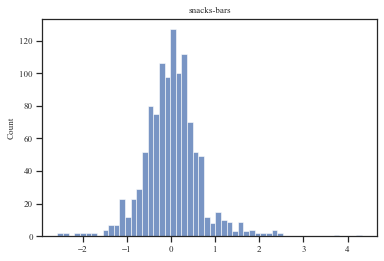


$$$$$$$$$$$$$$$[snacks-chips] price ~ FPro --> coef: -2.3117 RLM: -2.3283x + -5.9506 (pval: 2.958786131356021e-40) | count: 864


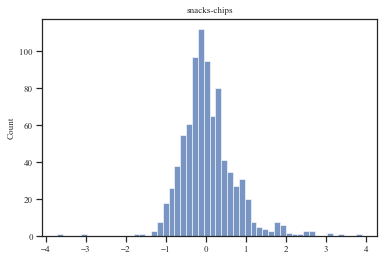


$$$$$$$$$$$$$$$[snacks-dips-salsa] price ~ FPro --> coef: -1.2071 RLM: -1.1421x + -4.8865 (pval: 0.011385658442865789) | count: 282


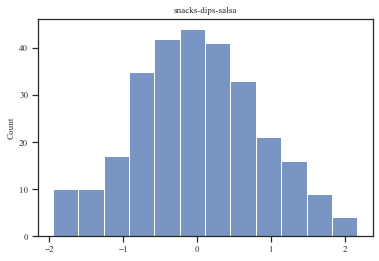


$$$$$$$$$$$$$$$[snacks-mixes-crackers] price ~ FPro --> coef: -2.1386 RLM: -2.3132x + -5.9063 (pval: 1.0213676621056262e-41) | count: 938


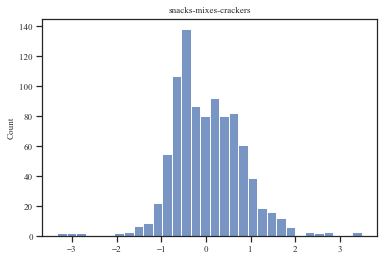


$$$$$$$$$$$$$$$[snacks-nuts-seeds] price ~ FPro --> coef: 0.3795 RLM: 0.3243x + -5.3680 (pval: 0.0026438504118766336) | count: 296


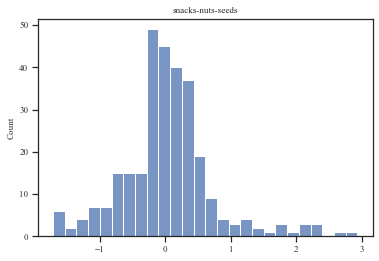


$$$$$$$$$$$$$$$[snacks-popcorn] price ~ FPro --> coef: 0.4650 RLM: 0.3703x + -5.6264 (pval: 0.37891155738014903) | count: 184


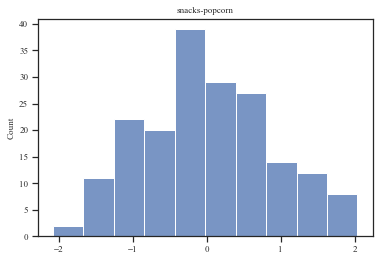


$$$$$$$$$$$$$$$[soup-stew] price ~ FPro --> coef: -2.6104 RLM: -2.9783x + -5.2932 (pval: 5.94075692066175e-36) | count: 505


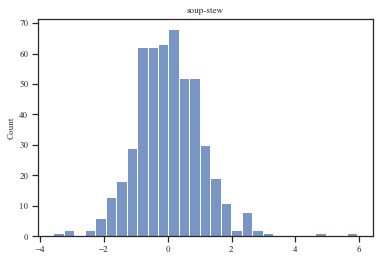


$$$$$$$$$$$$$$$[spices-seasoning] price ~ FPro --> coef: -0.6391 RLM: -0.5304x + -4.3631 (pval: 2.7765002527914524e-06) | count: 107



$$$$$$$$$$$$$$$[spread-squeeze] price ~ FPro --> coef: 0.0459 RLM: 0.0452x + -5.3852 (pval: 0.6864012074009969) | count: 236


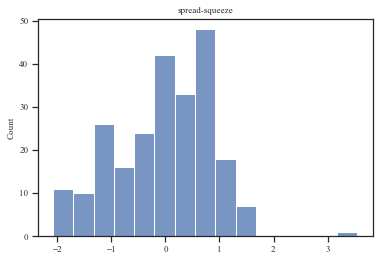

In [114]:
fpro_min = 0.0
reg_results = []

col_price = 'price percal'
standardized = ['', ' Standardized'][0]
print('standardized:', standardized)

for cat in ['ALL'] + list(gdb_conv_df[col_categories].unique()):
    
#     if cat != 'milk-milk-substitute':
#         continue
    
    if cat == 'ALL':
        cat_price_df = gdb_conv_df[[col_categories, 'f_FPro', col_price, 'store']]
    else:
        cat_price_df = gdb_conv_df[gdb_conv_df[col_categories] == cat][[col_categories, 'f_FPro', col_price, 'store']]
        
    cat_price_df = cat_price_df[
        (~cat_price_df[col_price].isnull()) 
        & (cat_price_df['f_FPro'] >= fpro_min)
    ].reset_index(drop=True)
    
    cat_price_df['f_FPro Standardized'] = cat_price_df['f_FPro'].apply(
        lambda fpro: grocery_base.normalizeBetweenTwoRanges(
            val=fpro, 
            minVal=cat_price_df['f_FPro'].min(), 
            maxVal=cat_price_df['f_FPro'].max(), 
            newMin=0,
            newMax=1
        )
    )
        
    cat_price_df[col_price + ' Standardized'] = cat_price_df[col_price].apply(
        lambda fpro: grocery_base.normalizeBetweenTwoRanges(
            val=fpro, 
            minVal=cat_price_df[col_price].min(), 
            maxVal=cat_price_df[col_price].max(), 
            newMin=0,
            newMax=1
        )
    )
    
    try:
        x_vals = cat_price_df['f_FPro' + standardized]
        
        x_vals = x_vals.apply(np.log)
        
        # to estimate % change
        if esitmate_perc_change_apply_log:
            x_vals = (x_vals * 100).apply(np.log)

        y = cat_price_df[col_price + standardized]
        
        y = y.apply(np.log)

        coef_np_polyfit = np.polyfit(x_vals, y, 1)

        X = np.c_[np.ones(len(x_vals)), x_vals]

        rlm_model = sm.RLM(y, X, sm.robust.norms.HuberT())
        
        rlm_results = rlm_model.fit()
        
        cat_price_df['rlm weights'] = rlm_results.weights
        
        reg_results.append({
            'cat': cat,
            'count items': len(cat_price_df) ,
            'OLS coef': coef_np_polyfit[0],
            'RLM coef': rlm_results.params[1],
            'RLM const': rlm_results.params[0],
            'RLM pvalue': rlm_results.pvalues[1]
        })
        
        if True:
            print('\n$$$$$$$$$$$$$$$[{}] price ~ FPro --> coef: {:.4f} RLM: {:.4f}x + {:.4f} (pval: {}) | count: {}'.format(
                cat, coef_np_polyfit[0], 
                rlm_results.params[1],
                rlm_results.params[0],
                rlm_results.pvalues[1],
                len(cat_price_df)
            ))

            
        if cat == 'ALL':
            g = sns.displot(data=rlm_results.resid)
        else:
            g = sns.histplot(rlm_results.resid)
            
        g.set(title=cat)
        plt.show()

        pass
    #         print(rlm_results.params)
    #         print(rlm_results.bse)

    #         print(
    #             rlm_results.summary(
    #                 yname="y", xname=["var_%d" % i for i in range(len(rlm_results.params))]
    #             )
    #         )

    except Exception as ex:
        print('\n-->> !!!!!!!!!!!!!!!!!!![Error] Category:', cat, ex)
        pass    
    
#     break
    
    pass
# [cookies-biscuit] coef: -0.0817 RLM: -0.0248 | count: 963

reg_results = pd.DataFrame(reg_results).sort_values('RLM coef')

In [115]:
def pval_star(pval):

    if pval < 0.001:
        return '***'

    elif 0.001 <= pval < 0.01:
        return '**'

    elif 0.01 <= pval < 0.05:
        return '*'

    elif 0.05 <= pval < 0.1:
        return ''#'.'
    else:
        return ''
            
    return row
    pass

reg_results['RLM coef pval'] = (
    reg_results['RLM coef'].round(4).astype(str) + '' +
    reg_results['RLM pvalue'].apply(lambda pval: pval_star(pval))
)

reg_results['RLM pval stars'] = (
    reg_results['RLM pvalue'].apply(lambda pval: pval_star(pval))
)

print('esitmate_perc_change_apply_log:', esitmate_perc_change_apply_log)

if esitmate_perc_change_apply_log:
    reg_results['PricePerCal Change % for 0.1 FPro'] = reg_results['RLM coef'] * 100 * 10

reg_results

esitmate_perc_change_apply_log: False


cat  count items  OLS coef  RLM coef  RLM const  \
5   cakes                    323         -3.724771 -4.807764 -5.964028    
16  drink-tea                45          -4.425029 -4.350784 -5.941285    
8   cookies-biscuit          961         -4.798116 -4.261918 -6.018173    
19  mac-cheese               199         -3.196411 -3.386159 -5.858664    
22  muffins-bagels           199         -2.926814 -3.254778 -5.849661    
41  soup-stew                505         -2.610437 -2.978282 -5.293246    
28  pudding-jello            201         -3.086608 -2.962741 -5.903231    
4   breakfast                246         -2.518878 -2.859196 -5.896506    
17  ice-cream-dessert        645         -2.204830 -2.536539 -5.945075    
12  drink-coffee             155         -2.363368 -2.365664 -5.318668    
14  drink-shakes-other       229         -2.261502 -2.338771 -5.275028    
36  snacks-chips             864         -2.311655 -2.328328 -5.950574    
38  snacks-mixes-crackers    938         -2.138587 -2.313219 -5.906344    
3   bread                    537         -1.777446 -2.016024 -5.917979    
30  rolls-buns-wraps         515         -1.475100 -1.785256 -5.739216    
31  salad                    88          -1.846836 -1.783627 -5.234706    
24  pastry-chocolate-candy   1310        -1.459656 -1.518406 -5.807669    
33  sausage-bacon            392         -1.401472 -1.488959 -5.589435    
13  drink-juice              296         -1.263493 -1.471392 -5.368980    
25  pizza                    337         -1.172062 -1.384604 -5.509214    
15  drink-soft-energy-mixes  88          -1.239502 -1.316012 -4.891167    
35  snacks-bars              1125        -1.310157 -1.306534 -5.266272    
32  sauce-all                517         -1.295247 -1.218448 -5.196132    
37  snacks-dips-salsa        282         -1.207133 -1.142126 -4.886462    
0   ALL                      19345       -0.814752 -0.948714 -5.438100    
11  dressings                435         -0.596933 -0.704525 -5.547354    
9   culinary-ingredients     141         -0.468508 -0.691032 -6.352825    
42  spices-seasoning         107         -0.639070 -0.530396 -4.363110    
26  prepared-meals-dishes    1627        -0.092467 -0.425972 -4.974678    
34  seafood                  328         -0.482772 -0.400308 -4.490517    
10  dairy-yogurt-drink       682         -0.342594 -0.372801 -4.816170    
20  meat-packaged            744         -0.343044 -0.367222 -4.674620    
1   baby-food                115         -0.148866 -0.141788 -3.786001    
29  rice-grains-packaged     114         -0.103812 -0.139897 -5.165645    
6   cereal                   659         -0.129841 -0.116413 -5.849545    
43  spread-squeeze           236          0.045885  0.045215 -5.385203    
2   baking                   324          0.195601  0.101411 -5.960596    
27  produce-packaged         947          0.146873  0.159649 -4.547724    
21  milk-milk-substitute     240          0.181195  0.163476 -4.607031    
39  snacks-nuts-seeds        296          0.379539  0.324327 -5.367973    
40  snacks-popcorn           184          0.465046  0.370328 -5.626404    
7   cheese                   783          0.218423  0.370555 -5.043480    
23  pasta-noodles            178          0.786400  0.611303 -5.506560    
18  jerky                    208          2.160282  1.489953 -3.170802    

      RLM pvalue RLM coef pval RLM pval stars  
5   2.193854e-30  -4.8078***    ***            
16  1.137022e-20  -4.3508***    ***            
8   1.882741e-68  -4.2619***    ***            
19  1.947466e-25  -3.3862***    ***            
22  1.005302e-12  -3.2548***    ***            
41  5.940757e-36  -2.9783***    ***            
28  9.076395e-26  -2.9627***    ***            
4   2.780368e-23  -2.8592***    ***            
17  3.019808e-29  -2.5365***    ***            
12  1.335598e-13  -2.3657***    ***            
14  2.540863e-16  -2.3388***    ***            
36  2.958786e-40  -2.3283***    ***            
38  1.021368e-41  -2.313

In [116]:
reg_results.to_excel('output/price_reg_log_log.xlsx')

esitmate_perc_change_apply_log: False


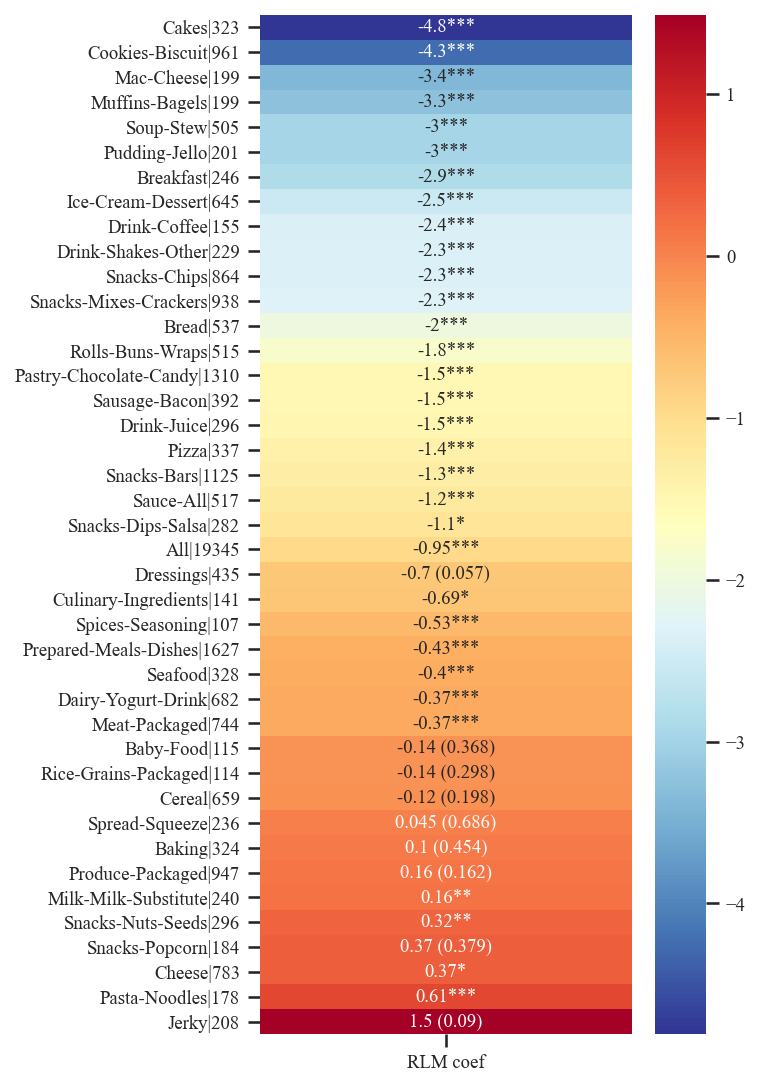

In [117]:
print('esitmate_perc_change_apply_log:', esitmate_perc_change_apply_log)

set_blank_for_not_sig = False

reg_results_c = reg_results.copy()

if set_blank_for_not_sig:
    reg_results_c.loc[reg_results_c['RLM pvalue'] > 0.05, 'RLM coef'] = None

res = grocery_base.plot_correlation_matrix(
    cat_corr_df=reg_results_c, 
    filter_min_num_items_in_category=100,
    cols_heatmap = ['RLM coef'], #, 'OLS coef'
#     title=f'PricePerCal ~ FPro | FPro min: {fpro_min}\nRegression Ordinary Least Squares & Robust Linear Model', 
    title=None, # to hide title
    figsize=(4, 9),
    font_size=9,
    add_count_items=True, 
#     vmin_vmax=(-0.15, 0.15)
)

g = res['g']
cat_corr_df = res['cat_corr_df']

if set_blank_for_not_sig:
    # the null ones (not sig) wont have a text in g.axes.texts
    cat_corr_df = cat_corr_df[cat_corr_df['RLM pval stars'] != ''].reset_index(drop=True)

if True:
    for i in range(len(g.axes.texts)):
        p_val = cat_corr_df['RLM pvalue'].round(3).values[i]
        if p_val >= 0.05:
            g.axes.texts[i]._text += '' + cat_corr_df['RLM pval stars'].values[i] + ' (' + str(p_val) + ')'
        else:
            g.axes.texts[i]._text += '' + cat_corr_df['RLM pval stars'].values[i] 
#         print(g.axes.texts[i]._text)
        pass

In [118]:
cat = ['ALL', 'soup-stew', 'cereal','milk-milk-substitute',
      'cakes', 'snacks-bars', 'pastry-chocolate-candy', 'mac-cheese', 'ice-cream-dessert'][3]

beta = reg_results[reg_results['cat'] == cat]['RLM coef'].values[0]

print(cat, 'beta:', beta)

p = 10

a = np.log((100 + p) / 100)

prop_change = np.exp(a*beta)

print('proportional change: ', prop_change)
print(round((prop_change - 1) * 100, 1))

milk-milk-substitute beta: 0.16347611087040884
proportional change:  1.0157029532103974
1.6


n_boot: 1000


''

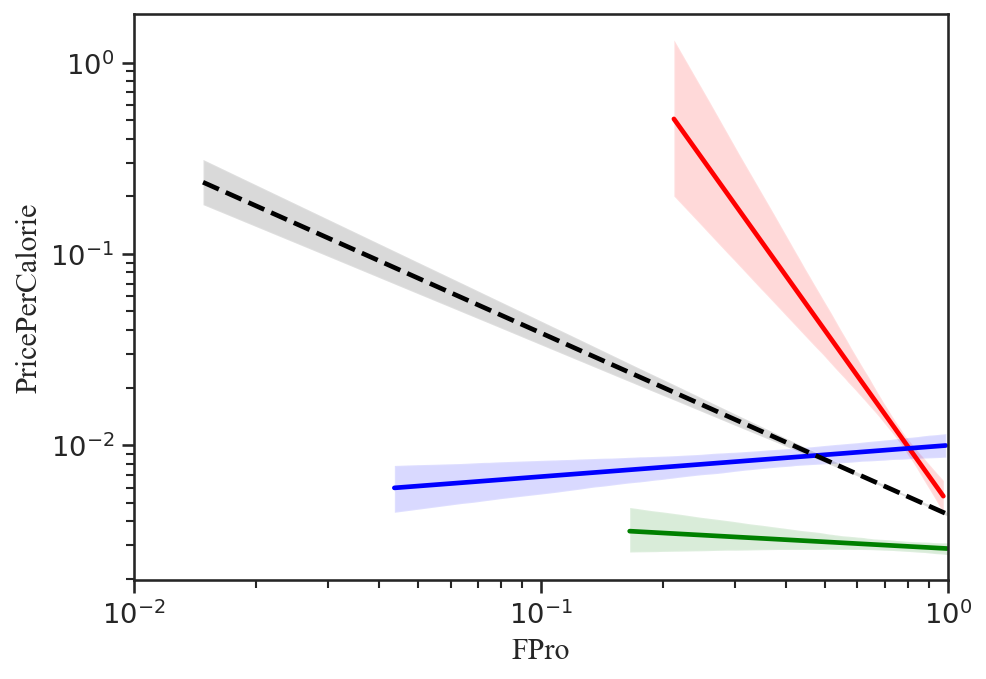

In [122]:
set_fonts(font_size =12, font_scale=1.2)

fig = plt.figure(figsize=(7, 5), dpi=150)
fpro_min = 0
n_boot = [1000, 10][0]

col_log = ['', ' log'][1]

print('n_boot:', n_boot)

data_df = gdb_conv_df[(gdb_conv_df[col_categories] == 'soup-stew') & (gdb_conv_df['f_FPro'] >= fpro_min)].copy()
data_df['f_FPro'+col_log] = data_df['f_FPro'].apply(np.log)
data_df['price percal'+col_log] = data_df['price percal'].apply(np.log)
ax = sns.regplot(x='f_FPro'+col_log, y='price percal'+col_log, data=data_df, n_boot=n_boot,
                 scatter=False, robust=True, x_estimator=np.mean, color='red')
# print(min(data_df['price percal'+col_log]))

# ['cakes', 'cookies-biscuit'][0]
data_df = gdb_conv_df[(gdb_conv_df[col_categories] == 'cereal') & (gdb_conv_df['f_FPro'] >= fpro_min)].copy()
data_df['f_FPro'+col_log] = data_df['f_FPro'].apply(np.log)
data_df['price percal'+col_log] = data_df['price percal'].apply(np.log)
sns.regplot(x='f_FPro'+col_log, y='price percal'+col_log, data=data_df, n_boot=n_boot,
            scatter=False, robust=True, x_estimator=np.mean, color='green', ax=ax)
# print(min(data_df['price percal'+col_log]))

# mac-cheese  pasta-noodles
data_df = gdb_conv_df[(gdb_conv_df[col_categories] == 'milk-milk-substitute') & (gdb_conv_df['f_FPro'] >= fpro_min)].copy()
data_df['f_FPro'+col_log] = data_df['f_FPro'].apply(np.log)
data_df['price percal'+col_log] = data_df['price percal'].apply(np.log)
sns.regplot(x='f_FPro'+col_log, y='price percal'+col_log, data=data_df,n_boot=n_boot,
            scatter=False, robust=True, x_estimator=np.mean, color='blue', ax=ax)
# print(min(data_df['price percal'+col_log]))

data_df = gdb_conv_df[(gdb_conv_df['f_FPro'] >= fpro_min)].copy()
data_df['f_FPro'+col_log] = data_df['f_FPro'].apply(np.log)
data_df['price percal'+col_log] = data_df['price percal'].apply(np.log)
sns.regplot(x='f_FPro'+col_log, y='price percal'+col_log, data=data_df, n_boot=n_boot, line_kws={'linestyle': '--'},
            scatter=False, robust=True, x_estimator=np.mean, color='black', ax=ax)
# print(min(data_df['price percal'+col_log]))


# ax.set_xticks(np.arange(-4.5, 0.1, 0.5))
# g.set(xlim=(-4,10))
ax.set(xlabel='FPro', ylabel='PricePerCalorie') # FPro

ax.set_xticks([np.log(10**0), np.log(10**-1), np.log(10**-2)])
ax.set_xticklabels(['$10^{0}$','$10^{-1}$','$10^{-2}$'])

ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(
    [
        np.log(0.02), np.log(0.03), np.log(0.04), np.log(0.05), np.log(0.06), np.log(0.07), np.log(0.08), np.log(0.09),
        np.log(0.2), np.log(0.3), np.log(0.4), np.log(0.5), np.log(0.6), np.log(0.7), np.log(0.8), np.log(0.9),
    ]
))

# plt.xscale('log')
# plt.yscale('log')

# ax.set_yscale('log')
# ax.set_yticks([0.001, 0.01])
# ax.set_xscale('log')

ax.set_yticks([np.log(10**-2), np.log(10**-1), np.log(10**0) ])
ax.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$'])

ax.yaxis.set_minor_locator(matplotlib.ticker.FixedLocator(
    [
        np.log(0.002), np.log(0.003), np.log(0.004), np.log(0.005), np.log(0.006), np.log(0.007), np.log(0.008), np.log(0.009),
        np.log(0.02), np.log(0.03), np.log(0.04), np.log(0.05), np.log(0.06), np.log(0.07), np.log(0.08), np.log(0.09),
        np.log(0.2), np.log(0.3), np.log(0.4), np.log(0.5), np.log(0.6), np.log(0.7), np.log(0.8), np.log(0.9),
    ]
))
# g.set(ylim=(0,10))

plt.savefig('output/fig3_A.pdf', dpi=300, bbox_inches='tight')

''

In [120]:
gdb_conv_df['price percal'].describe()

count    19345.000000
mean     0.012817    
std      0.114393    
min      0.000013    
25%      0.002870    
50%      0.005535    
75%      0.010947    
max      14.695269   
Name: price percal, dtype: float64

In [121]:
# it can take LOOONG
if False:
    fig = plt.figure(figsize=(6.5, 5), dpi=150)
    fpro_min = 0

    data_df = gdb_conv_df[gdb_conv_df[col_categories] == 'soup-stew']
    ax = sns.regplot(x='f_FPro', y='price percal', data=data_df[data_df['f_FPro'] >= fpro_min],
                     scatter=False, robust=True, x_estimator=np.mean, color='red')

    data_df = gdb_conv_df
    sns.regplot(x='f_FPro', y='price percal', data=data_df[data_df['f_FPro'] >= fpro_min],
                scatter=False, robust=True, x_estimator=np.mean, color='black', ax=ax, n_boot=1)


# End